In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import contextily as ctx
from sklearn.linear_model import HuberRegressor
from matplotlib.patches import FancyArrow
import os
from f_filter_process import call_file, export_dataframe
from matplotlib.colors import ListedColormap
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import TheilSenRegressor
from scipy.optimize import least_squares
import statsmodels.api as sm
from statsmodels. robust.norms import TukeyBiweight
from scipy.linalg import svd
from sklearn.linear_model import LinearRegression
import ruptures as rpt

In [ ]:
#os.chdir('..')
os.getcwd()

Call the geopackage (.gpkg)

In [3]:
river_shp = call_file()

Select the columns from the .gpkg to work with

In [4]:
river = river_shp[['node_id', 'lat', 'lon', 'width', 'width_u', 'wse', 'wse_u', 'p_dist_out', 'spearman_c', 'p_value_x', 'num_pairs_y', 'geometry']]
print(river)

             node_id       lat        lon       width   width_u       wse  \
0     61100200060011  7.727144 -77.139666  232.406756  5.079307   0.39787   
1     61100200060011  7.727143 -77.139702  250.821877  5.109340   2.05115   
2     61100200060011  7.727125 -77.139715  257.029157  4.597721   1.88379   
3     61100200060011  7.727117 -77.139692  242.345512  4.888369   1.72620   
4     61100200060011  7.727118 -77.139743  235.502396  4.440643   1.68157   
...              ...       ...        ...         ...       ...       ...   
6137  61100201270101  5.326663 -76.726895  146.828447  5.267849  47.47390   
6138  61100201270101  5.326663 -76.726770  115.063220  5.183047  46.99828   
6139  61100201270101  5.326764 -76.726799  121.740678  5.017838  47.11115   
6140  61100201270101  5.326702 -76.726842  115.959745  5.941951  47.09813   
6141  61100201270101  5.326665 -76.726946  141.822718  5.597958  48.03749   

        wse_u  p_dist_out  spearman_c  p_value_x  num_pairs_y  \
0     0.09

#### Testing normality

In [5]:
# Function to test normality for each node

def test_normality(gdf, node_col, width_col, wse_col, alpha=0.05):
    if gdf is None or gdf.empty:
        raise ValueError("Error: Input GeoDataFrame is empty or None.")
    
    if node_col not in gdf.columns or width_col not in gdf.columns or wse_col not in gdf.columns:
        raise ValueError("Error: One or more required columns are missing in the GeoDataFrame.")

    results = []
    min_samples = 3  # Minimum observations required for valid regression

    for node, group in gdf.groupby(node_col):
        if len(group) >= min_samples:
            X = group[[width_col]].values.reshape(-1, 1)
            y = group[wse_col].values

            # Standardize the data
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            # Initialize Huber Regressor with a higher max_iter
            huber = HuberRegressor(max_iter=1000)
            huber.fit(X_scaled, y)
            residuals = y - huber.predict(X_scaled)
            stat, p_value = stats.shapiro(residuals)
            normal_flag = p_value > alpha
        else:
            p_value, normal_flag = np.nan, False  # Not enough data

        results.append({node_col: node, 'p_value_norm': p_value, 'normal_flag': normal_flag})

    normality_df = pd.DataFrame(results)

    if normality_df.empty:
        raise ValueError("No valid normality results generated.")

    return gdf.merge(normality_df, on=node_col, how='left')

In [6]:
river_t = test_normality(river, node_col='node_id', width_col='width', wse_col='wse')

In [ ]:
river_t

In [ ]:
export_dataframe(river_t,is_geodataframe = True)

In [ ]:
def plot_qq_plots(gdf, node_col, width_col, wse_col):
    random_nodes = random.sample(gdf[node_col].unique().tolist(), min(20, len(gdf[node_col].unique())))
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, node in enumerate(random_nodes):
        subset = gdf[gdf[node_col] == node]
        if len(subset) > 3:
            X = subset[[width_col]].values.reshape(-1, 1)
            y = subset[wse_col].values
            huber = HuberRegressor()
            huber.fit(X, y)
            residuals = y - huber.predict(X)
            res = stats.probplot(residuals, dist="norm")
            axes[i].scatter(res[0][0], res[0][1], s=12, color='firebrick', alpha=0.9)  # Adjust dot size and color
            axes[i].plot(res[0][0], res[1][0] * res[0][0] + res[1][1], color='darkgray', linestyle='-', linewidth=1.5)
            
            # Get normality test result
            p_value = subset['p_value_norm'].iloc[0]
            passed = subset['normal_flag'].iloc[0]
            status = 'Pass' if passed else 'Fail'
            color = '#0072B2' if passed else '#E69F00'
            
            axes[i].set_title(f'Node {node}\n{status}', fontsize=10, color=color)
            axes[i].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()


In [ ]:
plot_qq_plots(river_t, node_col='node_id', width_col='width', wse_col='wse')

In [ ]:
def plot_p_value_histogram(gdf):
    plt.figure(figsize=(10, 6))
    sns.histplot(gdf.drop_duplicates(subset=['node_id'])['p_value_norm'].dropna(), bins=25, kde=True, color='lightsteelblue', edgecolor='black', alpha=0.8)
    plt.axvline(0.05, color='red', linestyle='--', label='Alpha = 0.05')
    plt.xlabel('p-value', fontsize=12)
    plt.ylabel('Number of Nodes', fontsize=12)
    plt.title('Histogram of Normality Test p-values', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Compute pass/fail statistics
    unique_nodes = gdf.drop_duplicates(subset=['node_id'])
    total_nodes = len(unique_nodes)
    passing_nodes = unique_nodes['normal_flag'].sum()
    failing_nodes = total_nodes - passing_nodes
    pass_percentage = (passing_nodes / total_nodes) * 100 if total_nodes > 0 else 0
    fail_percentage = (failing_nodes / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Inset with pass/fail summary (better positioning and proper categorical handling)
    inset_ax = plt.gca().inset_axes([0.62, 0.55, 0.3, 0.3])  # Adjusted position to fit well within the figure
    categories = ['Pass', 'Fail']
    values = [passing_nodes, failing_nodes]
    inset_ax.bar(range(len(categories)), values, color=["#56B4E9", "#E69F00"], edgecolor='black', alpha=0.9)
    inset_ax.set_xticks(range(len(categories)))
    inset_ax.set_xticklabels(categories)
    inset_ax.set_title('Test Results', fontsize=10, fontweight='bold')
    inset_ax.set_ylabel('Nodes', fontsize=9)
    inset_ax.tick_params(axis='both', which='major', labelsize=9)
    
    # Add text labels inside bars
    for i, v in enumerate(values):
        inset_ax.text(i, v / 2, f'{(v / total_nodes) * 100:.1f}%', ha='center', color='black', fontsize=9, weight='bold')
    
    plt.show()

In [ ]:
plot_p_value_histogram(river_t)

In [ ]:
# Function to plot heatmap
def plot_heatmap(gdf, node_col, dist_col='p_dist_out'):
    # Compute pass/fail statistics
    unique_nodes = gdf.drop_duplicates(subset=[node_col]).copy()
    total_nodes = len(unique_nodes)
    unique_nodes['pass_fail'] = unique_nodes['p_value_norm'] >= 0.05  # True = Pass, False = Fail
    passing_nodes = unique_nodes['pass_fail'].sum()
    failing_nodes = total_nodes - passing_nodes
    pass_percentage = (passing_nodes / total_nodes) * 100 if total_nodes > 0 else 0
    fail_percentage = (failing_nodes / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Sort nodes by distance from outlet in descending order (upstream first)
    unique_nodes = unique_nodes.sort_values(by=dist_col, ascending=False)
    
    # Reshape data to binary pass/fail heatmap
    summary_table = unique_nodes.pivot_table(index=node_col, values='pass_fail')
    summary_table = summary_table.reindex(unique_nodes[node_col].values)  # Ensure the order is maintained
    
    plt.figure(figsize=(15, 1.8))
    cmap = sns.color_palette(["#E69F00","#0072B2"])  # Blue for pass, Orange for fail
    ax = sns.heatmap(summary_table.T, cmap=cmap, cbar=True, linewidths=0.7, vmin=0, vmax=1, cbar_kws={'ticks': [0, 1]})
    
    # Modify color bar labels
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.25, 0.75])  # Adjust tick positions for visibility
    colorbar.set_ticklabels(["Fail (<0.05)", "Pass (≥0.05)"])
    
    # Add arrow to indicate decreasing distance downstream
    plt.xlabel('Nodes (Ordered by Distance to Outlet →)')
    plt.annotate('Outlet', xy=(0.98, -0.02), xycoords='axes fraction', fontsize=8, color='black', ha='left', va='top', fontweight='bold')
    
    plt.title(f'Binary Heatmap of Normality Test Results (Sorted by Distance to Outlet)\nPass: {passing_nodes} ({pass_percentage:.1f}%) | Fail: {failing_nodes} ({fail_percentage:.1f}%)')
    plt.xticks([])
    plt.show()


In [ ]:
plot_heatmap(river_t, node_col='node_id')

In [ ]:
def perform_huber_regression(gdf, node_col, width_col, wse_col, normal_flag_col):
    results = []
    for node, subset in gdf.groupby(node_col):
        if len(subset) > 3:
            X = subset[[width_col]].values.reshape(-1, 1)
            y = subset[wse_col].values
            
            # Skip if variance is too low (ill-conditioned data)
            if np.var(X) < 1e-6 or np.var(y) < 1e-6:
                continue
            
            try:
                # Initial Huber Regression to compute residuals for epsilon estimation
                huber = HuberRegressor()
                huber.fit(X, y)
                initial_residuals = y - huber.predict(X)
                
                # Compute epsilon based on normality flag
                is_normal = subset[normal_flag_col].iloc[0]
                if is_normal:
                    mad = np.median(np.abs(initial_residuals - np.median(initial_residuals))) * 1.4826
                    epsilon = max(1.35, min(mad * 1.5, 15.0))  # Ensure reasonable range
                else:
                    iqr = np.percentile(initial_residuals, 75) - np.percentile(initial_residuals, 25)
                    epsilon = max(1.35, min(iqr / 1.349 * 2, 15.0))
                
                # If epsilon is too large, reduce it slightly
                if epsilon > 8.0:
                    epsilon *= 0.75  # Reduce by 25% to prevent over-influence
                
                # Refit Huber with adaptive epsilon
                huber = HuberRegressor(epsilon=epsilon, max_iter=500)
                huber.fit(X, y)
                y_pred = huber.predict(X)
                final_residuals = y - y_pred
                
                # Compute regression statistics
                slope = huber.coef_[0]
                intercept = huber.intercept_
                r2 = r2_score(y, y_pred)
                
                # Assign predicted values and residuals to the original dataframe
                gdf.loc[subset.index, 'predicted_wse_huber'] = y_pred
                gdf.loc[subset.index, 'residuals_huber'] = final_residuals

                results.append({
                    node_col: node,
                    'slope_Hub': slope,
                    'intercept_Hub': intercept,
                    'r2_score': r2,
                    'epsilon': epsilon
                })
            except ValueError as e:
                print(f"⚠️ Huber regression failed for node {node}: {e}")
    
    results_df = pd.DataFrame(results)
    gdf = gdf.merge(results_df, on=node_col, how='left')
    return gdf


In [ ]:
river_Hub = perform_huber_regression(river_t, node_col='node_id', width_col='width', wse_col='wse',normal_flag_col='normal_flag')

In [ ]:
river_Hub

In [ ]:
export_dataframe(river_Hub,is_geodataframe = True)

## Alternative Huber

In [ ]:
def compute_aic(rss, n, k):
    # AIC = n*ln(RSS/n) + 2k
    return n * np.log(rss / n) + 2 * k

def adaptive_huber_fit(X, y, is_normal):
    """
    Fit a HuberRegressor with an adaptive epsilon computed from an initial fit.
    
    Parameters:
      - X: design matrix.
      - y: target values.
      - is_normal: Boolean flag indicating if residuals are normally distributed.
      
    Returns:
      - huber: fitted HuberRegressor model.
      - y_pred: predictions from the adaptive model.
      - final_residuals: residuals from the adaptive fit.
      - epsilon: the computed epsilon value.
    """
    # Initial fit with a default epsilon (1.35) and limited iterations.
    temp_model = HuberRegressor(epsilon=1.35, max_iter=500)
    temp_model.fit(X, y)
    initial_y_pred = temp_model.predict(X)
    initial_residuals = y - initial_y_pred
    
    # Compute adaptive epsilon based on the distribution of residuals.
    if is_normal:
        mad = np.median(np.abs(initial_residuals - np.median(initial_residuals))) * 1.4826
        epsilon = max(1.35, min(mad * 1.5, 15.0))
    else:
        iqr = np.percentile(initial_residuals, 75) - np.percentile(initial_residuals, 25)
        epsilon = max(1.35, min(iqr / 1.349 * 2, 15.0))
    
    # If epsilon is too large, reduce it slightly.
    if epsilon > 8.0:
        epsilon *= 0.75  # Reduce by 25%
    
    # Refit Huber with adaptive epsilon.
    huber = HuberRegressor(epsilon=epsilon, max_iter=500)
    huber.fit(X, y)
    y_pred = huber.predict(X)
    final_residuals = y - y_pred
    return huber, y_pred, final_residuals, epsilon

def piecewise_linear_huber_aic(gdf, node_col='node_id', normal_col='normal_flag'):
    """
    For each node (group defined by node_col) in gdf, fit three candidate models using adaptive Huber regression:
      1. A simple linear regression (k=2).
      2. A one-breakpoint piecewise linear regression (k=3).
      3. A two-breakpoint (three-segment) piecewise regression (k=4).

    Adaptive epsilon:
      - For each candidate, an initial fit is performed to compute residuals.
      - If the Boolean flag in normal_col is True, epsilon is computed from the MAD of the initial residuals.
      - Otherwise, epsilon is computed from the IQR.
      - In both cases, epsilon is constrained to be at least 1.35 and at most 15.0, and further reduced by 25% if above 8.0.

    Overfitting restrictions:
      - For nodes with 10 to 15 observations: each segment must have at least 3 observations.
      - For nodes with 16 or more observations: each segment must have at least 30% of observations.

    Results are stored in new columns:
      - 'model_type': 'simple', 'one_breakpoint', or 'two_breakpoints'
      - 'h0', 'h1', 'h2', 'h3': model parameters (for a simple regression h2 and h3 will be 0)
      - 'best_breakpoint1', 'best_breakpoint2': breakpoints (NaN if not used)
      - 'predicted_wse': model predictions
      - 'residuals': residuals
      - 'AIC': the AIC of the chosen model
      - Additionally, the effective slopes and intercepts for each segment are stored in:
            'final_intercept_1', 'final_slope_1',
            'final_intercept_2', 'final_slope_2',
            'final_intercept_3', 'final_slope_3'

    Parameters:
      - gdf: DataFrame with at least columns 'width' and 'wse', plus a Boolean column (default name 'is_normal')
      - node_col: the column name used to group nodes
      - normal_col: the column name with Booleans indicating normality of residuals

    Returns:
      - gdf: DataFrame updated with the new regression results.
    """
    # Initialize new columns
    gdf['model_type'] = None  
    gdf['h0'] = np.nan
    gdf['h1'] = np.nan
    gdf['h2'] = np.nan
    gdf['h3'] = np.nan
    gdf['best_breakpoint1'] = np.nan
    gdf['best_breakpoint2'] = np.nan
    gdf['predicted_wse'] = np.nan
    gdf['residuals'] = np.nan
    gdf['AIC'] = np.nan

    # New columns for effective slopes and intercepts
    gdf['final_intercept_1'] = np.nan
    gdf['final_slope_1'] = np.nan
    gdf['final_intercept_2'] = np.nan
    gdf['final_slope_2'] = np.nan
    gdf['final_intercept_3'] = np.nan
    gdf['final_slope_3'] = np.nan

    # Process each node group.
    for node, group in gdf.groupby(node_col):
        x = group['width'].values
        y = group['wse'].values
        n = len(x)
        if n < 3:
            continue

        # The normality flag is taken from the group's first row.
        is_normal = group[normal_col].iloc[0]

        candidate_results = {}  # keys: 'simple', 'one_breakpoint', 'two_breakpoints'

        ########################
        # 1. Simple Linear Regression (k=2)
        ########################
        X_simple = x.reshape(-1, 1)
        try:
            model, y_pred_simple, residuals, eps_used = adaptive_huber_fit(X_simple, y, is_normal)
        except Exception:
            continue
        rss_simple = np.sum(residuals**2)
        aic_simple = compute_aic(rss_simple, n, 2)
        candidate_results['simple'] = {
            'AIC': aic_simple,
            'h0': model.intercept_,
            'h1': model.coef_[0],
            'h2': 0.0,
            'h3': 0.0,
            'bp1': np.nan,
            'bp2': np.nan,
            'pred': y_pred_simple,
            'model_type': 'simple'
        }

        ########################
        # 2. One-Breakpoint Piecewise (k=3)
        ########################
        best_aic_one = np.inf
        best_bp_one = None
        best_params_one = None
        best_pred_one = None
        candidate_found = False
        candidate_breakpoints = np.unique(x)[1:-1]  # exclude extremes

        for bp in candidate_breakpoints:
            left_count = np.sum(x <= bp)
            right_count = np.sum(x > bp)
            if 10 <= n <= 15:
                if left_count < 3 or right_count < 3:
                    continue
            elif n >= 16:
                if left_count < 0.3 * n or right_count < 0.3 * n:
                    continue

            X = np.column_stack([x, np.maximum(0, x - bp)])
            try:
                model, y_pred_candidate, residuals, eps_used = adaptive_huber_fit(X, y, is_normal)
            except Exception:
                continue

            h0_candidate = model.intercept_
            h1_candidate = model.coef_[0]
            # For x > bp, effective slope becomes h1_candidate + coef_[1]
            h2_candidate = h1_candidate + model.coef_[1]
            if h1_candidate < 0 or h2_candidate < 0:
                continue
            # Check that the breakpoint produces a sufficient intercept difference.
            if abs(model.coef_[1] * bp) < 0.6:
                continue

            rss_candidate = np.sum(residuals**2)
            aic_candidate = compute_aic(rss_candidate, n, 3)

            if aic_candidate < best_aic_one:
                best_aic_one = aic_candidate
                best_bp_one = bp
                best_params_one = (h0_candidate, h1_candidate, model.coef_[1])
                best_pred_one = y_pred_candidate
                candidate_found = True

        if candidate_found:
            candidate_results['one_breakpoint'] = {
                'AIC': best_aic_one,
                'h0': best_params_one[0],
                'h1': best_params_one[1],
                'h2': best_params_one[1] + best_params_one[2],
                'h3': 0.0,
                'bp1': best_bp_one,
                'bp2': np.nan,
                'pred': best_pred_one,
                'model_type': 'one_breakpoint'
            }

        ########################
        # 3. Two-Breakpoint Piecewise (k=4)
        ########################
        best_aic_two = np.inf
        best_bp1_two = None
        best_bp2_two = None
        best_params_two = None
        best_pred_two = None
        candidate_found_two = False

        unique_vals = np.unique(x)
        if len(unique_vals) >= 3:
            for i in range(1, len(unique_vals) - 1):
                for j in range(i + 1, len(unique_vals)):
                    bp1 = unique_vals[i]
                    bp2 = unique_vals[j]
                    count_seg1 = np.sum(x <= bp1)
                    count_seg2 = np.sum((x > bp1) & (x <= bp2))
                    count_seg3 = np.sum(x > bp2)
                    if 10 <= n <= 15:
                        if count_seg1 < 3 or count_seg2 < 3 or count_seg3 < 3:
                            continue
                    elif n >= 16:
                        if count_seg1 < 0.3 * n or count_seg2 < 0.3 * n or count_seg3 < 0.3 * n:
                            continue

                    X = np.column_stack([x, np.maximum(0, x - bp1), np.maximum(0, x - bp2)])
                    try:
                        model, y_pred_candidate, residuals, eps_used = adaptive_huber_fit(X, y, is_normal)
                    except Exception:
                        continue

                    beta0 = model.intercept_
                    beta1, beta2, beta3 = model.coef_
                    s1 = beta1
                    s2 = beta1 + beta2
                    s3 = beta1 + beta2 + beta3
                    if s1 < 0 or s2 < 0 or s3 < 0:
                        continue
                    if abs(beta2 * bp1) < 0.6 or abs(beta3 * bp2) < 0.6:
                        continue

                    rss_candidate = np.sum(residuals**2)
                    aic_candidate = compute_aic(rss_candidate, n, 4)
                    if aic_candidate < best_aic_two:
                        best_aic_two = aic_candidate
                        best_bp1_two = bp1
                        best_bp2_two = bp2
                        best_params_two = (beta0, beta1, beta2, beta3)
                        best_pred_two = y_pred_candidate
                        candidate_found_two = True

        if candidate_found_two:
            candidate_results['two_breakpoints'] = {
                'AIC': best_aic_two,
                'h0': best_params_two[0],
                'h1': best_params_two[1],
                # For the two-breakpoint candidate, we store:
                # h2 = beta1 + beta2, and h3 = beta3.
                'h2': best_params_two[1] + best_params_two[2],
                'h3': best_params_two[3],
                'bp1': best_bp1_two,
                'bp2': best_bp2_two,
                'pred': best_pred_two,
                'model_type': 'two_breakpoints'
            }

        # Select best candidate based on AIC.
        best_model_type = None
        best_aic = np.inf
        for model_type, res in candidate_results.items():
            if res['AIC'] < best_aic:
                best_aic = res['AIC']
                best_model_type = model_type
        if best_model_type is None:
            best_model = candidate_results['simple']
        else:
            best_model = candidate_results[best_model_type]

        # Store chosen model results back into the DataFrame.
        idx = group.index
        gdf.loc[idx, 'model_type'] = best_model['model_type']
        gdf.loc[idx, 'h0'] = best_model['h0']
        gdf.loc[idx, 'h1'] = best_model['h1']
        gdf.loc[idx, 'h2'] = best_model['h2']
        gdf.loc[idx, 'h3'] = best_model.get('h3', 0.0)
        gdf.loc[idx, 'best_breakpoint1'] = best_model['bp1']
        gdf.loc[idx, 'best_breakpoint2'] = best_model['bp2']
        gdf.loc[idx, 'predicted_wse'] = best_model['pred']
        gdf.loc[idx, 'residuals'] = y - best_model['pred']
        gdf.loc[idx, 'AIC'] = best_model['AIC']

        # Compute and store effective slopes and intercepts for the chosen model.
        if best_model['model_type'] == 'simple':
            # Simple model: one segment.
            gdf.loc[idx, 'final_intercept_1'] = best_model['h0']
            gdf.loc[idx, 'final_slope_1'] = best_model['h1']
            gdf.loc[idx, 'final_intercept_2'] = np.nan
            gdf.loc[idx, 'final_slope_2'] = np.nan
            gdf.loc[idx, 'final_intercept_3'] = np.nan
            gdf.loc[idx, 'final_slope_3'] = np.nan
        elif best_model['model_type'] == 'one_breakpoint':
            # One-breakpoint model: two segments.
            seg1_int = best_model['h0']
            seg1_slope = best_model['h1']
            seg2_int = best_model['h0'] - (best_model['h2'] - best_model['h1']) * best_model['bp1']
            seg2_slope = best_model['h2']
            gdf.loc[idx, 'final_intercept_1'] = seg1_int
            gdf.loc[idx, 'final_slope_1'] = seg1_slope
            gdf.loc[idx, 'final_intercept_2'] = seg2_int
            gdf.loc[idx, 'final_slope_2'] = seg2_slope
            gdf.loc[idx, 'final_intercept_3'] = np.nan
            gdf.loc[idx, 'final_slope_3'] = np.nan
        elif best_model['model_type'] == 'two_breakpoints':
            # Two-breakpoints model: three segments.
            beta0 = best_model['h0']
            beta1 = best_model['h1']
            beta2 = best_model['h2'] - beta1  # increment for segment 2.
            beta3 = best_model['h3']
            seg1_int = beta0
            seg1_slope = beta1
            seg2_int = beta0 - beta2 * best_model['bp1']
            seg2_slope = beta1 + beta2
            seg3_int = beta0 - beta2 * best_model['bp1'] - beta3 * best_model['bp2']
            seg3_slope = beta1 + beta2 + beta3
            gdf.loc[idx, 'final_intercept_1'] = seg1_int
            gdf.loc[idx, 'final_slope_1'] = seg1_slope
            gdf.loc[idx, 'final_intercept_2'] = seg2_int
            gdf.loc[idx, 'final_slope_2'] = seg2_slope
            gdf.loc[idx, 'final_intercept_3'] = seg3_int
            gdf.loc[idx, 'final_slope_3'] = seg3_slope

    return gdf

In [ ]:
Linear_Hub_atl = piecewise_linear_huber_aic(gdf = river_t)

In [ ]:
Linear_Hub_atl

In [ ]:
def plot_node_regression(gdf, node_id, node_col='node_id'):
    """
    Plots the observed data and piecewise regression for a given node_id,
    with each segment in a different color and the legend showing the effective
    intercept and slope of each segment.
    
    Parameters:
      - gdf: GeoDataFrame that includes the regression results from piecewise_linear_huber_aic.
      - node_id: the node_id value to plot.
      - node_col: column name for the node identifier (default 'node_id').
    """
    # Filter the GeoDataFrame for the specified node and sort by 'width'.
    subset = gdf[gdf[node_col] == node_id].copy()
    if subset.empty:
        print(f"No data found for node_id: {node_id}")
        return
    subset.sort_values(by='width', inplace=True)
    
    # Extract observed data.
    x_obs = subset['width'].values
    y_obs = subset['wse'].values
    
    # Determine model type and breakpoints.
    model_type = subset['model_type'].iloc[0]
    bp1 = subset['best_breakpoint1'].iloc[0]
    bp2 = subset['best_breakpoint2'].iloc[0]
    
    # Create a new figure.
    plt.figure(figsize=(10, 6))
    
    # Plot observed data.
    plt.scatter(x_obs, y_obs, color='blue', label='Observed data')
    
    # Define colors for segments.
    colors = {
        'seg1': 'red',
        'seg2': 'green',
        'seg3': 'blue'
    }
    
    x_min, x_max = np.min(x_obs), np.max(x_obs)
    
    if model_type == 'simple':
        # For a simple model, use the final effective parameters for segment 1.
        seg1_int = subset['final_intercept_1'].iloc[0]
        seg1_slope = subset['final_slope_1'].iloc[0]
        x_line = np.linspace(x_min, x_max, 200)
        y_line = seg1_int + seg1_slope * x_line
        plt.plot(x_line, y_line, color=colors['seg1'],
                 label=f'Segment 1 (All data): intercept = {seg1_int:.2f}, slope = {seg1_slope:.2f}')
    
    elif model_type == 'one_breakpoint':
        # For one-breakpoint model: segment 1 (x <= bp1) and segment 2 (x > bp1).
        seg1_int = subset['final_intercept_1'].iloc[0]
        seg1_slope = subset['final_slope_1'].iloc[0]
        seg2_int = subset['final_intercept_2'].iloc[0]
        seg2_slope = subset['final_slope_2'].iloc[0]
        
        # Define segment ranges.
        x_line_seg1 = np.linspace(x_min, bp1, 100)
        x_line_seg2 = np.linspace(bp1, x_max, 100)
        y_line_seg1 = seg1_int + seg1_slope * x_line_seg1
        y_line_seg2 = seg2_int + seg2_slope * x_line_seg2
        
        plt.plot(x_line_seg1, y_line_seg1, color=colors['seg1'],
                 label=f'Segment 1 (x ≤ {bp1:.2f}): intercept = {seg1_int:.2f}, slope = {seg1_slope:.2f}')
        plt.plot(x_line_seg2, y_line_seg2, color=colors['seg2'],
                 label=f'Segment 2 (x > {bp1:.2f}): intercept = {seg2_int:.2f}, slope = {seg2_slope:.2f}')
        
        # Mark the breakpoint.
        plt.axvline(x=bp1, color='purple', linestyle='--', label=f'Breakpoint: {bp1:.2f}')
    
    elif model_type == 'two_breakpoints':
        # For two-breakpoint model: segment 1 (x <= bp1), segment 2 (bp1 < x ≤ bp2) and segment 3 (x > bp2).
        seg1_int = subset['final_intercept_1'].iloc[0]
        seg1_slope = subset['final_slope_1'].iloc[0]
        seg2_int = subset['final_intercept_2'].iloc[0]
        seg2_slope = subset['final_slope_2'].iloc[0]
        seg3_int = subset['final_intercept_3'].iloc[0]
        seg3_slope = subset['final_slope_3'].iloc[0]
        
        # Define segment ranges.
        x_line_seg1 = np.linspace(x_min, bp1, 100)
        x_line_seg2 = np.linspace(bp1, bp2, 100)
        x_line_seg3 = np.linspace(bp2, x_max, 100)
        y_line_seg1 = seg1_int + seg1_slope * x_line_seg1
        y_line_seg2 = seg2_int + seg2_slope * x_line_seg2
        y_line_seg3 = seg3_int + seg3_slope * x_line_seg3
        
        plt.plot(x_line_seg1, y_line_seg1, color=colors['seg1'],
                 label=f'Segment 1 (x ≤ {bp1:.2f}): intercept = {seg1_int:.2f}, slope = {seg1_slope:.2f}')
        plt.plot(x_line_seg2, y_line_seg2, color=colors['seg2'],
                 label=f'Segment 2 ({bp1:.2f} < x ≤ {bp2:.2f}): intercept = {seg2_int:.2f}, slope = {seg2_slope:.2f}')
        plt.plot(x_line_seg3, y_line_seg3, color=colors['seg3'],
                 label=f'Segment 3 (x > {bp2:.2f}): intercept = {seg3_int:.2f}, slope = {seg3_slope:.2f}')
        
        # Mark both breakpoints.
        plt.axvline(x=bp1, color='black', linestyle='--', label=f'Breakpoint 1: {bp1:.2f}')
        plt.axvline(x=bp2, color='gray', linestyle='--', label=f'Breakpoint 2: {bp2:.2f}')
    
    # Set labels and title.
    plt.xlabel("Width")
    plt.ylabel("WSE")
    plt.title(f"Piecewise Regression for node_id: {node_id} ({model_type})")
    plt.legend()
    plt.show()


In [ ]:
plot_node_regression(Linear_Hub_atl, node_id='21406100110481')

# Huber Piecewise (2 segments)
This is the one that is going to be used

In [7]:
def compute_aic(rss, n, k):
    # AIC = n*ln(RSS/n) + 2k
    return n * np.log(rss / n) + 2 * k

def adaptive_huber_fit(X, y, is_normal):
    """
    Fit a HuberRegressor with an adaptive epsilon computed from an initial fit.
    
    Parameters:
      - X: design matrix.
      - y: target values.
      - is_normal: Boolean flag indicating if residuals are normally distributed.
      
    Returns:
      - huber: fitted HuberRegressor model.
      - y_pred: predictions from the adaptive model.
      - final_residuals: residuals from the adaptive fit.
      - epsilon: the computed epsilon value.
    """
    # Initial fit with a default epsilon (1.35) and limited iterations.
    temp_model = HuberRegressor(epsilon=1.35, max_iter=500)
    temp_model.fit(X, y)
    initial_y_pred = temp_model.predict(X)
    initial_residuals = y - initial_y_pred
    
    # Compute adaptive epsilon based on the distribution of residuals.
    if is_normal:
        mad = np.median(np.abs(initial_residuals - np.median(initial_residuals))) * 1.4826
        epsilon = max(1.35, min(mad * 1.5, 15.0))
    else:
        iqr = np.percentile(initial_residuals, 75) - np.percentile(initial_residuals, 25)
        epsilon = max(1.35, min(iqr / 1.349 * 2, 15.0))
    
    # If epsilon is too large, reduce it slightly.
    if epsilon > 8.0:
        epsilon *= 0.75  # Reduce by 25%
    
    # Refit Huber with adaptive epsilon.
    huber = HuberRegressor(epsilon=epsilon, max_iter=500)
    huber.fit(X, y)
    y_pred = huber.predict(X)
    final_residuals = y - y_pred
    return huber, y_pred, final_residuals, epsilon

def piecewise_linear_huber_2seg_aic(gdf, node_col='node_id', normal_col='normal_flag'):
    """
    For each node (group defined by node_col) in gdf, fit two candidate models using adaptive Huber regression:
      1. A simple linear regression (k=2).
      2. A one-breakpoint piecewise linear regression (k=3).
    
    Adaptive epsilon:
      - For each candidate, an initial fit is performed to compute residuals.
      - If the Boolean flag in normal_col is True, epsilon is computed from the MAD of the initial residuals.
      - Otherwise, epsilon is computed from the IQR.
      - In both cases, epsilon is constrained to be at least 1.35 and at most 15.0, and further reduced by 25% if above 8.0.
    
    Overfitting restrictions:
      - For nodes with 10 to 15 observations: each segment must have at least 3 observations.
      - For nodes with 16 or more observations: each segment must have at least 30% of observations.
    
    Additional restriction:
      - In a one-breakpoint candidate, if both effective slopes (for x ≤ breakpoint and x > breakpoint)
        lie in the range [0.9, 1] (both included), then that candidate is rejected so that the simple
        linear regression model is used instead.
    
    Results are stored in new columns:
      - 'model_type': 'simple' or 'one_breakpoint'
      - 'h0', 'h1', 'h2', 'h3': model parameters (for a simple regression, h2 and h3 will be 0)
      - 'best_breakpoint1': breakpoint (NaN if not used)
      - 'predicted_wse': model predictions
      - 'residuals': residuals
      - 'AIC': the AIC of the chosen model
      - Additionally, the effective slopes and intercepts for each segment are stored in:
            'final_intercept_1', 'final_slope_1',
            'final_intercept_2', 'final_slope_2',
            'final_intercept_3', 'final_slope_3'
    
    Parameters:
      - gdf: DataFrame with at least columns 'width' and 'wse', plus a Boolean column (default name 'normal_flag')
      - node_col: the column name used to group nodes
      - normal_col: the column name with Booleans indicating normality of residuals
    
    Returns:
      - gdf: DataFrame updated with the new regression results.
    """
    # Initialize new columns
    gdf['model_type'] = None  
    gdf['h0'] = np.nan
    gdf['h1'] = np.nan
    gdf['h2'] = np.nan
    gdf['h3'] = np.nan
    gdf['best_breakpoint1'] = np.nan
    gdf['predicted_wse'] = np.nan
    gdf['residuals'] = np.nan
    gdf['AIC'] = np.nan

    # New columns for effective slopes and intercepts
    gdf['final_intercept_1'] = np.nan
    gdf['final_slope_1'] = np.nan
    gdf['final_intercept_2'] = np.nan
    gdf['final_slope_2'] = np.nan
    gdf['final_intercept_3'] = np.nan
    gdf['final_slope_3'] = np.nan

    # Tolerance range for slopes that lie between 0.9 and 1.
    lower_bound = 0.9
    upper_bound = 1.0

    # Process each node group.
    for node, group in gdf.groupby(node_col):
        x = group['width'].values
        y = group['wse'].values
        n = len(x)
        if n < 3:
            continue

        # The normality flag is taken from the group's first row.
        is_normal = group[normal_col].iloc[0]

        candidate_results = {}  # keys: 'simple', 'one_breakpoint'

        ########################
        # 1. Simple Linear Regression (k=2)
        ########################
        X_simple = x.reshape(-1, 1)
        try:
            model, y_pred_simple, residuals, eps_used = adaptive_huber_fit(X_simple, y, is_normal)
        except Exception:
            continue
        rss_simple = np.sum(residuals**2)
        aic_simple = compute_aic(rss_simple, n, 2)
        candidate_results['simple'] = {
            'AIC': aic_simple,
            'h0': model.intercept_,
            'h1': model.coef_[0],
            'h2': 0.0,
            'h3': 0.0,
            'bp1': np.nan,
            'pred': y_pred_simple,
            'model_type': 'simple'
        }

        ########################
        # 2. One-Breakpoint Piecewise (k=3)
        ########################
        best_aic_one = np.inf
        best_bp_one = None
        best_params_one = None
        best_pred_one = None
        candidate_found = False
        candidate_breakpoints = np.unique(x)[1:-1]  # exclude extremes

        for bp in candidate_breakpoints:
            left_count = np.sum(x <= bp)
            right_count = np.sum(x > bp)
            if 10 <= n <= 15:
                if left_count < 3 or right_count < 3:
                    continue
            elif n >= 16:
                if left_count < 0.3 * n or right_count < 0.3 * n:
                    continue

            X_candidate = np.column_stack([x, np.maximum(0, x - bp)])
            try:
                model, y_pred_candidate, residuals, eps_used = adaptive_huber_fit(X_candidate, y, is_normal)
            except Exception:
                continue

            h0_candidate = model.intercept_
            h1_candidate = model.coef_[0]
            # For x > bp, effective slope becomes h1_candidate + coef_[1]
            h2_candidate = h1_candidate + model.coef_[1]

            # Reject candidate if any effective slope is negative.
            if h1_candidate < 0 or h2_candidate < 0:
                continue

            # Additional restriction:
            # If both effective slopes lie in the range [0.9, 1] (inclusive), reject the piecewise candidate.
            if (lower_bound <= h1_candidate <= upper_bound) or (lower_bound <= h2_candidate <= upper_bound):
                continue

            # Check that the breakpoint produces a sufficient intercept difference.
            if abs(model.coef_[1] * bp) < 0.6:
                continue

            rss_candidate = np.sum(residuals**2)
            aic_candidate = compute_aic(rss_candidate, n, 3)

            if aic_candidate < best_aic_one:
                best_aic_one = aic_candidate
                best_bp_one = bp
                best_params_one = (h0_candidate, h1_candidate, model.coef_[1])
                best_pred_one = y_pred_candidate
                candidate_found = True

        if candidate_found:
            candidate_results['one_breakpoint'] = {
                'AIC': best_aic_one,
                'h0': best_params_one[0],
                'h1': best_params_one[1],
                'h2': best_params_one[1] + best_params_one[2],
                'h3': 0.0,
                'bp1': best_bp_one,
                'pred': best_pred_one,
                'model_type': 'one_breakpoint'
            }

        # Select best candidate based on AIC.
        best_model_type = None
        best_aic = np.inf
        for key, res in candidate_results.items():
            if res['AIC'] < best_aic:
                best_aic = res['AIC']
                best_model_type = key
        if best_model_type is None:
            best_model = candidate_results['simple']
        else:
            best_model = candidate_results[best_model_type]

        # Store chosen model results back into the DataFrame.
        idx = group.index
        gdf.loc[idx, 'model_type'] = best_model['model_type']
        gdf.loc[idx, 'h0'] = best_model['h0']
        gdf.loc[idx, 'h1'] = best_model['h1']
        gdf.loc[idx, 'h2'] = best_model['h2']
        gdf.loc[idx, 'h3'] = best_model.get('h3', 0.0)
        gdf.loc[idx, 'best_breakpoint1'] = best_model['bp1']
        gdf.loc[idx, 'predicted_wse'] = best_model['pred']
        gdf.loc[idx, 'residuals'] = y - best_model['pred']
        gdf.loc[idx, 'AIC'] = best_model['AIC']

        # Compute and store effective slopes and intercepts for the chosen model.
        if best_model['model_type'] == 'simple':
            # Simple model: one segment.
            gdf.loc[idx, 'final_intercept_1'] = best_model['h0']
            gdf.loc[idx, 'final_slope_1'] = best_model['h1']
            gdf.loc[idx, 'final_intercept_2'] = np.nan
            gdf.loc[idx, 'final_slope_2'] = np.nan
            gdf.loc[idx, 'final_intercept_3'] = np.nan
            gdf.loc[idx, 'final_slope_3'] = np.nan
        elif best_model['model_type'] == 'one_breakpoint':
            # One-breakpoint model: two segments.
            seg1_int = best_model['h0']
            seg1_slope = best_model['h1']
            seg2_int = best_model['h0'] - (best_model['h2'] - best_model['h1']) * best_model['bp1']
            seg2_slope = best_model['h2']
            gdf.loc[idx, 'final_intercept_1'] = seg1_int
            gdf.loc[idx, 'final_slope_1'] = seg1_slope
            gdf.loc[idx, 'final_intercept_2'] = seg2_int
            gdf.loc[idx, 'final_slope_2'] = seg2_slope
            gdf.loc[idx, 'final_intercept_3'] = np.nan
            gdf.loc[idx, 'final_slope_3'] = np.nan

    return gdf

In [8]:
PW_linear2_Hub_AIC = piecewise_linear_huber_2seg_aic(river_t)

In [ ]:
PW_linear2_Hub_AIC

In [9]:
def plot_node_reg_2segs(gdf, node_id, node_col='node_id'):
    """
    Plots the observed data and fitted regression for a specific node_id.
    
    The function supports:
      - A simple model (one segment) where the fitted line is plotted over the entire range.
      - A one-breakpoint model (two segments) where:
          - Segment 1 is for x values <= breakpoint.
          - Segment 2 is for x values > breakpoint.
    
    Parameters:
      - gdf: DataFrame that includes the regression results from piecewise_linear_huber_aic.
      - node_id: the specific node_id to plot.
      - node_col: the column name used for node identification (default 'node_id').
    """
    # Filter data for the specified node_id and sort by 'width'.
    subset = gdf[gdf[node_col] == node_id].copy()
    if subset.empty:
        print(f"No data found for node_id: {node_id}")
        return
    subset.sort_values(by='width', inplace=True)
    
    x_obs = subset['width'].values
    y_obs = subset['wse'].values
    model_type = subset['model_type'].iloc[0]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_obs, y_obs, color='blue', label='Observed data')
    
    # Plot according to the model type.
    if model_type == 'simple':
        seg1_int = subset['final_intercept_1'].iloc[0]
        seg1_slope = subset['final_slope_1'].iloc[0]
        x_line = np.linspace(np.min(x_obs), np.max(x_obs), 200)
        y_line = seg1_int + seg1_slope * x_line
        plt.plot(x_line, y_line, color='red',
                 label=f"Segment 1 (All data): intercept = {seg1_int:.2f}, slope = {seg1_slope:.2f}")
    
    elif model_type == 'one_breakpoint':
        bp = subset['best_breakpoint1'].iloc[0]
        seg1_int = subset['final_intercept_1'].iloc[0]
        seg1_slope = subset['final_slope_1'].iloc[0]
        seg2_int = subset['final_intercept_2'].iloc[0]
        seg2_slope = subset['final_slope_2'].iloc[0]
        
        # Create piecewise segments.
        x_line_seg1 = np.linspace(np.min(x_obs), bp, 100)
        y_line_seg1 = seg1_int + seg1_slope * x_line_seg1
        x_line_seg2 = np.linspace(bp, np.max(x_obs), 100)
        y_line_seg2 = seg2_int + seg2_slope * x_line_seg2
        
        plt.plot(x_line_seg1, y_line_seg1, color='red',
                 label=f"Segment 1 (x ≤ {bp:.2f}): intercept = {seg1_int:.2f}, slope = {seg1_slope:.2f}")
        plt.plot(x_line_seg2, y_line_seg2, color='green',
                 label=f"Segment 2 (x > {bp:.2f}): intercept = {seg2_int:.2f}, slope = {seg2_slope:.2f}")
        plt.axvline(x=bp, color='purple', linestyle='--', label=f"Breakpoint: {bp:.2f}")
    
    plt.xlabel("Width")
    plt.ylabel("WSE")
    plt.title(f"Regression for node_id: {node_id} ({model_type})")
    plt.legend()
    plt.show()


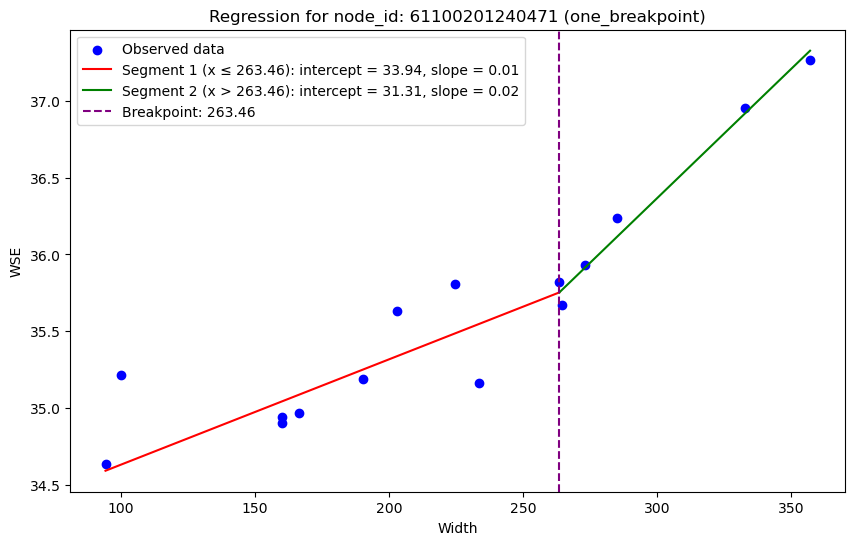

In [12]:
plot_node_reg_2segs(PW_linear2_Hub_AIC, node_id='61100201240471') # 61100200360511(ATR)

In [ ]:
def plot_random_nodes_Hub(gdf, num_nodes=20, node_col='node_id'):
    """
    Randomly selects num_nodes unique node IDs from the GeoDataFrame and plots
    their piecewise regressions in a grid of subplots.
    
    Parameters:
      - gdf: GeoDataFrame with regression results. It must contain at least the columns
             'width', 'wse', 'model_type', 'best_breakpoint1', and (if applicable) 
             'best_breakpoint2', as well as final effective parameters.
      - num_nodes: number of nodes to plot (default 20).
      - node_col: column name for the node identifier.
    """
    # Get unique node IDs.
    unique_nodes = gdf[node_col].unique()
    if len(unique_nodes) < num_nodes:
        num_nodes = len(unique_nodes)
    selected_nodes = np.random.choice(unique_nodes, size=num_nodes, replace=False)
    
    # Create a grid of subplots.
    ncols = 5
    nrows = int(np.ceil(num_nodes / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
    axes = axes.flatten()
    
    # Define colors for segments.
    colors = {'seg1': 'red', 'seg2': 'green', 'seg3': 'blue'}
    
    for ax, node in zip(axes, selected_nodes):
        # Filter and sort the data for the current node.
        subset = gdf[gdf[node_col] == node].copy()
        if subset.empty:
            continue
        subset.sort_values(by='width', inplace=True)
        x_obs = subset['width'].values
        y_obs = subset['wse'].values
        
        # Determine model type and breakpoints.
        model_type = subset['model_type'].iloc[0]
        bp1 = subset['best_breakpoint1'].iloc[0] if 'best_breakpoint1' in subset.columns else np.nan
        bp2 = subset['best_breakpoint2'].iloc[0] if 'best_breakpoint2' in subset.columns else np.nan
        
        # Plot the observed data.
        ax.scatter(x_obs, y_obs, color='blue', label='Observed data')
        x_min, x_max = np.min(x_obs), np.max(x_obs)
        
        if model_type == 'simple':
            seg1_int = subset['final_intercept_1'].iloc[0]
            seg1_slope = subset['final_slope_1'].iloc[0]
            x_line = np.linspace(x_min, x_max, 200)
            y_line = seg1_int + seg1_slope * x_line
            ax.plot(x_line, y_line, color=colors['seg1'],
                    label=f'Seg1 (All): int = {seg1_int:.2f}, slope = {seg1_slope:.2f}')
        
        elif model_type == 'one_breakpoint':
            seg1_int = subset['final_intercept_1'].iloc[0]
            seg1_slope = subset['final_slope_1'].iloc[0]
            seg2_int = subset['final_intercept_2'].iloc[0]
            seg2_slope = subset['final_slope_2'].iloc[0]
            
            x_line_seg1 = np.linspace(x_min, bp1, 100)
            x_line_seg2 = np.linspace(bp1, x_max, 100)
            y_line_seg1 = seg1_int + seg1_slope * x_line_seg1
            y_line_seg2 = seg2_int + seg2_slope * x_line_seg2
            
            ax.plot(x_line_seg1, y_line_seg1, color=colors['seg1'],
                    label=f'Seg1 (x ≤ {bp1:.2f}): int = {seg1_int:.2f}, slope = {seg1_slope:.2f}')
            ax.plot(x_line_seg2, y_line_seg2, color=colors['seg2'],
                    label=f'Seg2 (x > {bp1:.2f}): int = {seg2_int:.2f}, slope = {seg2_slope:.2f}')
            ax.axvline(x=bp1, color='purple', linestyle='--', label=f'BP: {bp1:.2f}')
        
        elif model_type == 'two_breakpoints':
            seg1_int = subset['final_intercept_1'].iloc[0]
            seg1_slope = subset['final_slope_1'].iloc[0]
            seg2_int = subset['final_intercept_2'].iloc[0]
            seg2_slope = subset['final_slope_2'].iloc[0]
            seg3_int = (subset['final_intercept_3'].iloc[0]
                        if 'final_intercept_3' in subset.columns else np.nan)
            seg3_slope = (subset['final_slope_3'].iloc[0]
                          if 'final_slope_3' in subset.columns else np.nan)
            
            x_line_seg1 = np.linspace(x_min, bp1, 100)
            x_line_seg2 = np.linspace(bp1, bp2, 100)
            x_line_seg3 = np.linspace(bp2, x_max, 100)
            y_line_seg1 = seg1_int + seg1_slope * x_line_seg1
            y_line_seg2 = seg2_int + seg2_slope * x_line_seg2
            if not np.isnan(seg3_int) and not np.isnan(seg3_slope):
                y_line_seg3 = seg3_int + seg3_slope * x_line_seg3
            else:
                y_line_seg3 = None
            
            ax.plot(x_line_seg1, y_line_seg1, color=colors['seg1'],
                    label=f'Seg1 (x ≤ {bp1:.2f}): int = {seg1_int:.2f}, slope = {seg1_slope:.2f}')
            ax.plot(x_line_seg2, y_line_seg2, color=colors['seg2'],
                    label=f'Seg2 ({bp1:.2f} < x ≤ {bp2:.2f}): int = {seg2_int:.2f}, slope = {seg2_slope:.2f}')
            if y_line_seg3 is not None:
                ax.plot(x_line_seg3, y_line_seg3, color=colors['seg3'],
                        label=f'Seg3 (x > {bp2:.2f}): int = {seg3_int:.2f}, slope = {seg3_slope:.2f}')
            ax.axvline(x=bp1, color='black', linestyle='--', label=f'BP1: {bp1:.2f}')
            ax.axvline(x=bp2, color='gray', linestyle='--', label=f'BP2: {bp2:.2f}')
        
        ax.set_xlabel("Width")
        ax.set_ylabel("WSE")
        ax.set_title(f"node_id: {node} ({model_type})")
        ax.legend(fontsize='x-small', loc='best')
    
    # Hide any unused subplots.
    for i in range(num_nodes, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
plot_random_nodes_Hub(PW_linear2_Hub_AIC)

### Theil-Sen Regression

In [ ]:
river_t['slope_theil'] = np.nan
river_t['intercept_theil'] = np.nan
river_t['predicted_wse_theil'] = np.nan
river_t['residuals_theil'] = np.nan

In [ ]:
def theil_sen_linear(gdf, node_col):
    for node, group in gdf.groupby(node_col):
        width = group[['width']].values
        wse = group['wse'].values

        model = TheilSenRegressor()
        model.fit(width, wse)

        slope = model.coef_[0]
        intercept = model.intercept_
        predicted_wse_theil = model.predict(width)
        residuals = wse - predicted_wse_theil

        gdf.loc[group.index, 'slope_theil'] = slope
        gdf.loc[group.index, 'intercept_theil'] = intercept
        gdf.loc[group.index, 'predicted_wse_theil'] = predicted_wse_theil
        gdf.loc[group.index, 'residuals_theil'] = residuals

    return gdf

In [ ]:
river_Hub = theil_sen_linear(river_Hub, node_col='node_id')
river_Hub

In [ ]:
export_dataframe(river_theil_sen_lin,is_geodataframe = True)

### Tukey's biweight M-estimator

In [ ]:
river_t['slope_tukey'] = np.nan
river_t['intercept_tukey'] = np.nan
river_t['predicted_wse_tukey'] = np.nan

In [ ]:
def tukey_linear(gdf, node_col = 'node_id'):
    for node, group in gdf.groupby(node_col):
        width = group[['width']]
        width = sm.add_constant(width)
        wse = group['wse']

        model = sm.RLM(wse, width, M=TukeyBiweight())
        results = model.fit()

        gdf.loc[group.index, 'slope_tukey'] = results.params['width']
        gdf.loc[group.index, 'intercept_tukey'] = results.params['const']
        gdf.loc[group.index, 'predicted_wse_tukey'] = results.predict(width)
        gdf.loc[group.index, 'residuals_tukey'] = wse - results.predict(width)

    return gdf


In [ ]:
river_Hub = tukey_linear(river_Hub)
river_Hub

In [ ]:
real_bath = pd.read_csv('./0_data/Manual/Basins/Bath/Atrato.csv')
real_bath['node_id'] = real_bath['node_id'].astype(int).astype(str)
river_Hub = river_Hub.merge(real_bath[['node_id', 'real_wsemin']], on='node_id', how='left')
if 'real_wsemin_x' and 'real_wsemin_y' in river_Hub.columns:
    river_Hub = river_Hub.drop(columns=['real_wsemin_x'])

In [ ]:
river_Hub

In [ ]:
river_realdata = river_Hub[river_Hub['real_wsemin'].notna()].copy()
river_realdata['residuals_theil'] = river_realdata['real_wsemin'] - river_realdata['predicted_wse_theil']

plt.figure(figsize=(12,10))

# 1. Residual vs FItted Values plot

plt.subplot(2, 2, 1)
sns.scatterplot(x='predicted_wse_theil', y='residuals_theil', data=river_realdata)
plt.axhline(0, color = 'red', linestyle = '--')
plt.xlabel('Predicted WSE (Theil)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Theil)')

# 2. Histogram of Residuals with Density Plot
plt.subplot(2, 2, 2)
sns.histplot(river_realdata['residuals_theil'], kde=True, color='skyblue')
plt.xlabel('Residuals')
plt.title('Histogram of Residuals (Theil)')

# 3. Q-Q Plot
plt.subplot(2, 2, 3)
sm.qqplot(river_realdata['residuals_theil'], line ='45', fit=True, ax=plt.gca())

# 4. Scale-Location Plot
plt.subplot(2, 2, 4)
sns.scatterplot(x='predicted_wse_theil', y=np.sqrt(np.abs(river_realdata['residuals_theil'])), data=river_realdata)
plt.xlabel('Predicted WSE (Theil)')
plt.ylabel('Sqrt(|Residuals|)')
plt.title('Scale-Location Plot (Theil)')

plt.tight_layout()
plt.show()


### Error in Variables

In [ ]:
def fullers_eiv_regression(gdf, node_col = 'node_id'):
    """
    Performs Error-in-Variables (EIV) regression following Fuller's (1987) method using Total Least Squares (TLS).
    This method accounts for errors in both 'width' and 'wse' based on their provided standard deviations.
    Stores the results with the prefix 'EIV_'.
    
    Parameters:
        gdf (GeoDataFrame): Input GeoDataFrame containing 'width', 'wse', 'std_width', and 'std_wse'.
        node_col (str): Column name indicating node identifiers.

    Returns:
        GeoDataFrame: Updated GeoDataFrame with EIV regression results.
    """
    gdf['EIV_slope'] = np.nan
    gdf['EIV_intercept'] = np.nan
    gdf['EIV_predicted_wse'] = np.nan
    gdf['EIV_residuals'] = np.nan
    
    for node, group in gdf.groupby(node_col):
        width = group['width'].values.reshape(-1, 1)
        wse = group['wse'].values.reshape(-1, 1)
        std_width = group['width_u'].values.reshape(-1, 1)
        std_wse = group['wse_u'].values.reshape(-1, 1)
        
        if len(width) < 2:
            continue  # Skip nodes with fewer than 2 points
        
        # Calculate error ratio per observation
        error_ratio = (std_width ** 2) / (std_wse ** 2)
        mean_error_ratio = np.mean(error_ratio)
        
        # Construct data matrix
        X = np.hstack([width, wse])
        
        # Perform Singular Value Decomposition (SVD)
        U, S, Vt = svd(X - np.mean(X, axis=0), full_matrices=False)
        
        # Compute corrected slope using Fuller's approach
        slope = (S[1] / S[0]) * (1 / mean_error_ratio)
        intercept = np.mean(wse) - slope * np.mean(width)
        
        predicted_wse_eiv = slope * width + intercept
        residuals = wse.flatten() - predicted_wse_eiv.flatten()
        
        gdf.loc[group.index, 'EIV_slope'] = slope
        gdf.loc[group.index, 'EIV_intercept'] = intercept
        gdf.loc[group.index, 'EIV_predicted_wse'] = predicted_wse_eiv.flatten()
        gdf.loc[group.index, 'EIV_residuals'] = residuals
    
    return gdf


In [ ]:
EIV = fullers_eiv_regression(river_t)

In [ ]:
EIV

### EIV using an L1 regression (Least Absolute Deviations)

In [ ]:
def l1_Eiv_regression(gdf, node_col = 'node_id', width_col = 'width', wse_col = 'wse', std_width_col = 'width_u', std_wse_col = 'wse_u'):
    """
    Performs Least Absolute Deviations (L1-norm) regression for each node, incorporating Error-in-Variables (EIV) adjustment.
    This method estimates the regression parameters by minimizing absolute residuals.
    Stores results with the prefix 'L1_'.
    
    Parameters:
        gdf (GeoDataFrame): Input GeoDataFrame containing 'width', 'wse', 'std_width', and 'std_wse'.
        node_col (str): Column name indicating node identifiers.
        width_col (str): Column name for width values.
        wse_col (str): Column name for wse values.
        std_width_col (str): Column name for standard deviation of width.
        std_wse_col (str): Column name for standard deviation of wse.

    Returns:
        GeoDataFrame: Updated GeoDataFrame with L1 regression results.
    """
    gdf["L1_slope"] = np.nan
    gdf["L1_intercept"] = np.nan
    gdf["L1_predicted_wse"] = np.nan
    gdf["L1_residuals"] = np.nan
    
    for node, group in gdf.groupby(node_col):
        if len(group) < 3:
            continue  # Skip nodes with fewer than 3 points
        
        width = group[width_col].values.reshape(-1, 1)
        wse = group[wse_col].values
        std_width = group[std_width_col].values.reshape(-1, 1)
        std_wse = group[std_wse_col].values.reshape(-1, 1)
        
        # Compute error ratio per observation
        error_ratio = (std_width ** 2) / (std_wse ** 2)
        mean_error_ratio = np.mean(error_ratio)
        
        try:
            # Fit Least Absolute Deviations (L1) Regression with alternative solver and increased iteration limit
            lad_model = sm.QuantReg(wse, sm.add_constant(width)).fit(q=0.5, solver='highs', max_iter=10000)
            
            # Apply EIV correction to slope and intercept
            slope = lad_model.params[1] * (1 / mean_error_ratio)  # Adjust slope
            intercept = np.mean(wse) - slope * np.mean(width)  # Adjust intercept
            
            predicted_wse = slope * width + intercept
            residuals = wse - predicted_wse.flatten()
            
            # Assign results to the dataframe
            gdf.loc[group.index, "L1_slope"] = slope
            gdf.loc[group.index, "L1_intercept"] = intercept
            gdf.loc[group.index, "L1_predicted_wse"] = predicted_wse.flatten()
            gdf.loc[group.index, "L1_residuals"] = residuals
        
        except Exception as e:
            print(f"Warning: L1 regression failed for node {node} - {e}")
            # Try alternative solver if primary fails
            try:
                lad_model = sm.QuantReg(wse, sm.add_constant(width)).fit(q=0.5, solver='highs-ds', max_iter=10000)
                
                slope = lad_model.params[1] * (1 / mean_error_ratio)
                intercept = np.mean(wse) - slope * np.mean(width)
                
                predicted_wse = slope * width + intercept
                residuals = wse - predicted_wse.flatten()
                
                gdf.loc[group.index, "L1_slope"] = slope
                gdf.loc[group.index, "L1_intercept"] = intercept
                gdf.loc[group.index, "L1_predicted_wse"] = predicted_wse.flatten()
                gdf.loc[group.index, "L1_residuals"] = residuals
            except Exception as e_alt:
                print(f"Warning: Alternative solver also failed for node {node} - {e_alt}")
    
    return gdf



In [ ]:
L1_EIV = l1_Eiv_regression(river_t)

In [ ]:
L1_EIV

### Huber and EIV

In [ ]:
def eiv_huber_regression(gdf, node_col = 'node_id', width_col = 'width', wse_col = 'wse', std_width_col = 'width_u', std_wse_col = 'wse_u', normal_flag_col = 'normal_flag'):
    """
    Performs Error-in-Variables regression using Huber Regression, incorporating Fuller's (1987) model.
    This method accounts for errors in both 'width' and 'wse' using their provided standard deviations and adapts Huber's epsilon.
    Stores results with the prefix 'EIV_Hub_'.
    
    Parameters:
        gdf (GeoDataFrame): Input GeoDataFrame containing 'width', 'wse', 'std_width', 'std_wse', and normality flag.
        node_col (str): Column name indicating node identifiers.
        width_col (str): Column name for width values.
        wse_col (str): Column name for wse values.
        std_width_col (str): Column name for standard deviation of width.
        std_wse_col (str): Column name for standard deviation of wse.
        normal_flag_col (str): Column indicating normality test results.

    Returns:
        GeoDataFrame: Updated GeoDataFrame with EIV Huber regression results.
    """
    gdf["EIV_Hub_slope"] = np.nan
    gdf["EIV_Hub_intercept"] = np.nan
    gdf["EIV_Hub_predicted_wse"] = np.nan
    gdf["EIV_Hub_residuals"] = np.nan
    gdf["EIV_Hub_r2_score"] = np.nan
    gdf["EIV_Hub_epsilon"] = np.nan
    
    for node, group in gdf.groupby(node_col):
        if len(group) < 3:
            continue  # Skip nodes with fewer than 3 points
        
        width = group[width_col].values.reshape(-1, 1)
        wse = group[wse_col].values
        std_width = group[std_width_col].values.reshape(-1, 1)
        std_wse = group[std_wse_col].values.reshape(-1, 1)
        
        # Compute error ratio per observation
        error_ratio = (std_width ** 2) / (std_wse ** 2)
        mean_error_ratio = np.mean(error_ratio)
        
        try:
            # Initial Huber Regression to compute residuals for epsilon estimation
            huber = HuberRegressor()
            huber.fit(width, wse)
            initial_residuals = wse - huber.predict(width)
            
            # Compute epsilon based on normality flag
            is_normal = group[normal_flag_col].iloc[0]
            if is_normal:
                mad = np.median(np.abs(initial_residuals - np.median(initial_residuals))) * 1.4826
                epsilon = max(1.35, min(mad * 1.5, 15.0))  # Ensure reasonable range
            else:
                iqr = np.percentile(initial_residuals, 75) - np.percentile(initial_residuals, 25)
                epsilon = max(1.35, min(iqr / 1.349 * 2, 15.0))
            
            # If epsilon is too large, reduce it slightly
            if epsilon > 8.0:
                epsilon *= 0.75  # Reduce by 25% to prevent over-influence
            
            # Refit Huber with adaptive epsilon
            huber = HuberRegressor(epsilon=epsilon, max_iter=500)
            huber.fit(width, wse)
            y_pred = huber.predict(width)
            final_residuals = wse - y_pred
            
            # Compute regression statistics
            slope = huber.coef_[0] * (1 / mean_error_ratio)  # Adjust slope using Fuller's approach
            intercept = huber.intercept_
            r2 = r2_score(wse, y_pred)
            
            # Assign predicted values and residuals to the original dataframe
            gdf.loc[group.index, "EIV_Hub_slope"] = slope
            gdf.loc[group.index, "EIV_Hub_intercept"] = intercept
            gdf.loc[group.index, "EIV_Hub_predicted_wse"] = y_pred
            gdf.loc[group.index, "EIV_Hub_residuals"] = final_residuals
            gdf.loc[group.index, "EIV_Hub_r2_score"] = r2
            gdf.loc[group.index, "EIV_Hub_epsilon"] = epsilon
        
        except ValueError as e:
            print(f"Warning: Huber regression failed for node {node} - {e}")
    
    return gdf

In [ ]:
Hub_EIV = eiv_huber_regression(river_t)

In [ ]:
Hub_EIV

### EIV-Theil-Sen

In [ ]:
def eiv_theil_sen_regression(gdf, node_col ='node_id', width_col = 'width', wse_col = 'wse', std_width_col = 'width_u', std_wse_col = 'wse_u'):
    """
    Performs Error-in-Variables regression using Theil-Sen estimator, incorporating Fuller's (1987) model.
    This method accounts for errors in both 'width' and 'wse' using their provided standard deviations.
    Stores results with the prefix 'EIV_Theil_'.
    
    Parameters:
        gdf (GeoDataFrame): Input GeoDataFrame containing 'width', 'wse', 'std_width', and 'std_wse'.
        node_col (str): Column name indicating node identifiers.
        width_col (str): Column name for width values.
        wse_col (str): Column name for wse values.
        std_width_col (str): Column name for standard deviation of width.
        std_wse_col (str): Column name for standard deviation of wse.

    Returns:
        GeoDataFrame: Updated GeoDataFrame with EIV Theil-Sen regression results.
    """
    gdf["EIV_Theil_slope"] = np.nan
    gdf["EIV_Theil_intercept"] = np.nan
    gdf["EIV_Theil_predicted_wse"] = np.nan
    gdf["EIV_Theil_residuals"] = np.nan
    
    for node, group in gdf.groupby(node_col):
        if len(group) < 3:
            continue  # Skip nodes with fewer than 3 points
        
        width = group[width_col].values.reshape(-1, 1)
        wse = group[wse_col].values
        std_width = group[std_width_col].values.reshape(-1, 1)
        std_wse = group[std_wse_col].values.reshape(-1, 1)
        
        # Compute error ratio per observation
        error_ratio = (std_width ** 2) / (std_wse ** 2)
        mean_error_ratio = np.mean(error_ratio)
        
        try:
            # Fit Theil-Sen Regression
            model = TheilSenRegressor()
            model.fit(width, wse)
            
            slope = model.coef_[0] * (1 / mean_error_ratio)  # Adjust slope using Fuller's approach
            intercept = model.intercept_
            predicted_wse = model.predict(width)
            residuals = wse - predicted_wse
            
            # Assign results to the dataframe
            gdf.loc[group.index, "EIV_Theil_slope"] = slope
            gdf.loc[group.index, "EIV_Theil_intercept"] = intercept
            gdf.loc[group.index, "EIV_Theil_predicted_wse"] = predicted_wse
            gdf.loc[group.index, "EIV_Theil_residuals"] = residuals
        
        except ValueError as e:
            print(f"Warning: Theil-Sen regression failed for node {node} - {e}")
    
    return gdf


In [ ]:
EIVeil = eiv_theil_sen_regression(river_t)

In [ ]:
EIVeil

### Pure L1 Regression

In [ ]:
def l1_regression(gdf, node_col = 'node_id', width_col = 'width', wse_col = 'wse'):
    """
    Performs Least Absolute Deviations (L1-norm) regression for each node.
    This method estimates the regression parameters by minimizing absolute residuals.
    Stores results with the prefix 'L1_'.
    
    Parameters:
        gdf (GeoDataFrame): Input GeoDataFrame containing 'width' and 'wse'.
        node_col (str): Column name indicating node identifiers.
        width_col (str): Column name for width values.
        wse_col (str): Column name for wse values.

    Returns:
        GeoDataFrame: Updated GeoDataFrame with L1 regression results.
    """
    gdf["L1_slope"] = np.nan
    gdf["L1_intercept"] = np.nan
    gdf["L1_predicted_wse"] = np.nan
    gdf["L1_residuals"] = np.nan
    
    for node, group in gdf.groupby(node_col):
        if len(group) < 3:
            continue  # Skip nodes with fewer than 3 points
        
        width = group[width_col].values.reshape(-1, 1)
        wse = group[wse_col].values
        
        try:
            # Fit Least Absolute Deviations (L1) Regression with alternative solver and increased iteration limit
            lad_model = sm.QuantReg(wse, sm.add_constant(width)).fit(q=0.5, solver='highs', max_iter=10000)
            
            slope = lad_model.params[1]  # Pure LAD slope
            intercept = lad_model.params[0]
            predicted_wse = slope * width + intercept
            residuals = wse - predicted_wse.flatten()
            
            # Assign results to the dataframe
            gdf.loc[group.index, "L1_slope"] = slope
            gdf.loc[group.index, "L1_intercept"] = intercept
            gdf.loc[group.index, "L1_predicted_wse"] = predicted_wse.flatten()
            gdf.loc[group.index, "L1_residuals"] = residuals
        
        except Exception as e:
            print(f"Warning: L1 regression failed for node {node} - {e}")
            # Try alternative solver if primary fails
            try:
                lad_model = sm.QuantReg(wse, sm.add_constant(width)).fit(q=0.5, solver='highs-ds', max_iter=10000)
                
                slope = lad_model.params[1]
                intercept = lad_model.params[0]
                predicted_wse = slope * width + intercept
                residuals = wse - predicted_wse.flatten()
                
                gdf.loc[group.index, "L1_slope"] = slope
                gdf.loc[group.index, "L1_intercept"] = intercept
                gdf.loc[group.index, "L1_predicted_wse"] = predicted_wse.flatten()
                gdf.loc[group.index, "L1_residuals"] = residuals
            except Exception as e_alt:
                print(f"Warning: Alternative solver also failed for node {node} - {e_alt}")
    
    return gdf


In [ ]:
L1 = l1_regression(river_t)

In [ ]:
L1

### Piecewise Theil-Sen Regression

In [ ]:
def piecewise_linear_theil_search(gdf, node_col = 'node_id'):
    """
    For each node (group defined by node_col) in gdf, this function searches for the optimal 
    breakpoint that minimizes the mean squared error of a piecewise linear regression model 
    (with a known continuity constraint).
    
    The piecewise model is:
        y = h0 + h1*x                     if x <= breakpoint
        y = h0 + h1*x + (h2 - h1)*(x - breakpoint)   if x > breakpoint
    which can be rewritten as:
        y = h0 + h1*x + beta2*max(0, x - breakpoint)
    where h0 = intercept, h1 = beta1 and h2 = beta1 + beta2.
    
    Parameters:
    - gdf: a DataFrame containing the data, with columns 'width' and 'wse'.
    - node_col: the name of the column used to group the data (e.g. a node identifier).
    
    Returns:
    - gdf: the input DataFrame updated with new columns:
           'h0', 'h1', 'h2' (the fitted parameters),
           'best_breakpoint' (the optimal breakpoint found),
           'predicted_wse_piecewise' and 'residuals_piecewise'.
    """
    
    # Initialize new columns with NaN
    gdf['h0'] = np.nan
    gdf['h1'] = np.nan
    gdf['h2'] = np.nan
    gdf['best_breakpoint'] = np.nan
    gdf['predicted_wse_piecewise'] = np.nan
    gdf['residuals_piecewise'] = np.nan
    
    # Process each group (node)
    for node, group in gdf.groupby(node_col):
        # Extract x (predictor) and y (response)
        x = group['width'].values
        y = group['wse'].values
        
        # If too few points, skip the group
        if len(x) < 3:
            continue
        
        # Get candidate breakpoints: use unique values, skipping the extreme values.
        unique_x = np.unique(x)
        if len(unique_x) < 3:
            continue  # not enough candidate breakpoints
        candidate_breakpoints = unique_x[1:-1]
        
        best_mse = np.inf
        best_breakpoint = None
        best_params = None
        best_pred = None
        
        # Grid search for the best breakpoint
        for bp in candidate_breakpoints:
            # Build design matrix:
            # First column: x, second column: max(0, x - bp)
            X = np.column_stack([x, np.maximum(0, x - bp)])
            
            model = TheilSenRegressor(max_iter=2000)
            try:
                model.fit(X, y)
            except Exception:
                continue  # if fitting fails, skip this candidate
            
            # Get predictions and compute mean squared error (MSE)
            pred = model.predict(X)
            mse = np.mean((y - pred)**2)
            
            if mse < best_mse:
                best_mse = mse
                best_breakpoint = bp
                best_params = (model.intercept_, model.coef_[0], model.coef_[1])
                best_pred = pred
        
        # If a best breakpoint was found, save the results back to the dataframe
        if best_breakpoint is not None:
            h0 = best_params[0]
            beta1 = best_params[1]  # corresponds to h1
            beta2 = best_params[2]  # extra parameter so that h2 = h1 + beta2
            h1 = beta1
            h2 = beta1 + beta2
            
            # Save the estimated parameters and breakpoint for each row in this group
            gdf.loc[group.index, 'h0'] = h0
            gdf.loc[group.index, 'h1'] = h1
            gdf.loc[group.index, 'h2'] = h2
            gdf.loc[group.index, 'best_breakpoint'] = best_breakpoint
            gdf.loc[group.index, 'predicted_wse_piecewise'] = best_pred
            gdf.loc[group.index, 'residuals_piecewise'] = y - best_pred
            
    return gdf

In [ ]:
piece_Theil = piecewise_linear_theil_search(river_t)

In [ ]:
piece_Theil

In [ ]:
def plot_node_piecewise_extended(gdf, node_id, node_col='node_id'):
    """
    Plot the piecewise linear regression for a specific node_id, showing:
      - Segment 1 (x <= breakpoint): y = h0 + h1*x 
      - Segment 2 (x > breakpoint): y = h0 + h1*x + (h2-h1)*(x-breakpoint)
        which is equivalent to: y = [h0 - (h2-h1)*breakpoint] + h2*x
      
    The function also calculates and displays the R² values for each segment.
    
    Parameters:
    - gdf: DataFrame containing:
         'width', 'wse', 'best_breakpoint', 'h0', 'h1', 'h2', and 'predicted_wse_piecewise'.
    - node_id: the node identifier to plot.
    - node_col: the name of the column that contains the node identifier (default 'node').
    
    Returns:
    - None. The function displays a matplotlib plot.
    """
    
    # Filter data for the specific node
    group = gdf[gdf[node_col] == node_id]
    if group.empty:
        print(f"No data found for {node_col} = {node_id}")
        return
    
    # Original data
    x = group['width'].values
    y = group['wse'].values
    
    # Retrieve the piecewise regression parameters (assumed constant for the node)
    h0 = group['h0'].iloc[0]
    h1 = group['h1'].iloc[0]
    h2 = group['h2'].iloc[0]
    bp = group['best_breakpoint'].iloc[0]
    
    # Effective intercept for segment 2: y = h0_seg2 + h2*x, where h0_seg2 = h0 - (h2-h1)*bp
    h0_seg2 = h0 - (h2 - h1) * bp
    
    # Create ranges for plotting each segment
    x_left = np.linspace(x.min(), bp, 100)
    y_left = h0 + h1 * x_left
    
    x_right = np.linspace(bp, x.max(), 100)
    y_right = h0 + h1 * x_right + (h2 - h1) * (x_right - bp)
    
    # Compute R² for segment 1 (x <= bp)
    mask_left = x <= bp
    if np.sum(mask_left) > 1:
        y_left_obs = y[mask_left]
        x_left_obs = x[mask_left]
        y_left_pred = h0 + h1 * x_left_obs
        r2_left = 1 - np.sum((y_left_obs - y_left_pred)**2) / np.sum((y_left_obs - np.mean(y_left_obs))**2)
    else:
        r2_left = np.nan
    
    # Compute R² for segment 2 (x > bp)
    mask_right = x > bp
    if np.sum(mask_right) > 1:
        y_right_obs = y[mask_right]
        x_right_obs = x[mask_right]
        y_right_pred = h0 + h1 * x_right_obs + (h2 - h1) * (x_right_obs - bp)
        r2_right = 1 - np.sum((y_right_obs - y_right_pred)**2) / np.sum((y_right_obs - np.mean(y_right_obs))**2)
    else:
        r2_right = np.nan
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot of data points
    plt.scatter(x, y, label="Data", alpha=0.7)
    
    # Plot segment 1 and segment 2 lines
    plt.plot(x_left, y_left, label=f"Segment 1 (x ≤ {bp:.2f})\nSlope = {h1:.2f}", lw=2)
    plt.plot(x_right, y_right, label=f"Segment 2 (x > {bp:.2f})\nSlope = {h2:.2f}", lw=2)
    
    # Vertical line at the breakpoint
    plt.axvline(bp, color='gray', linestyle='--', label=f"Breakpoint = {bp:.2f}")
    
    # Create an annotation text box with R² and intercept info
    textstr = (f"Segment 1 (x ≤ {bp:.2f}):\n"
               f"Intercept = {h0:.2f}\n"
               f"Slope = {h1:.2f}\n"
               f"R² = {r2_left:.2f}\n\n"
               f"Segment 2 (x > {bp:.2f}):\n"
               f"Intercept = {h0_seg2:.2f}\n"
               f"Slope = {h2:.2f}\n"
               f"R² = {r2_right:.2f}")
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xlabel("Width")
    plt.ylabel("WSE")
    plt.title(f"Piecewise Regression for {node_col} = {node_id}")
    plt.legend()
    plt.show()

In [ ]:
plot_node_piecewise_extended(river_t, node_id='61100201100181')

In [ ]:
def piecewise_linear_theil_limit(gdf, node_col='node_id'):
    """
    For each node (group defined by node_col) in gdf, this function attempts to fit a piecewise
    linear regression with up to two breakpoints (three segments) under the following criteria:
    
      - Overfitting restrictions:
          * For nodes with 10 to 15 observations: each segment must have at least 4 observations.
          * For nodes with 16 or more observations: each segment must have at least 30% of total observations.
      - None of the segment slopes may be negative.
      - For a three-segment model (with two breakpoints):
          * The model is: 
                y = β₀ + β₁*x + β₂*max(0, x - bp₁) + β₃*max(0, x - bp₂)
          * Slopes:
                Segment 1: s₁ = β₁  
                Segment 2: s₂ = β₁ + β₂  
                Segment 3: s₃ = β₁ + β₂ + β₃
          * Require: s₁ > 0, s₂ > 0, s₃ > 0.
          * Effective intercept differences: 
                |β₂ * bp₁| ≥ 0.6 and |β₃ * bp₂| ≥ 0.6.
      - If no valid candidate is found with two breakpoints, try a one-breakpoint model:
          * Model: y = h₀ + h₁*x + β₂*max(0, x - bp)
          * Slopes: 
                Segment 1: s₁ = coefficient for x  
                Segment 2: s₂ = (coefficient for x + β₂)
          * Require: s₁ > 0, s₂ > 0 and |β₂ * bp| ≥ 0.6.
      - If even the one-breakpoint model fails, perform a simple Theil-Sen regression.
    
    The results are stored in new columns:
      - For a three-segment model: 'h0', 'h1', 'h2', 'h3', 'best_breakpoint1', 'best_breakpoint2',
        'predicted_wse_piecewise', and 'residuals_piecewise'.
      - For a one-breakpoint model: 'h3' is set to 0 and best_breakpoint2 is NaN.
      - For a simple regression: best_breakpoint1 and best_breakpoint2 are NaN and h1, h2, h3 are such that
        the model is a single line.
    """
    # Initialize output columns
    gdf['h0'] = np.nan
    gdf['h1'] = np.nan
    gdf['h2'] = np.nan
    gdf['h3'] = np.nan
    gdf['best_breakpoint1'] = np.nan
    gdf['best_breakpoint2'] = np.nan
    gdf['predicted_wse_piecewise'] = np.nan
    gdf['residuals_piecewise'] = np.nan

    # Process each node group
    for node, group in gdf.groupby(node_col):
        x = group['width'].values
        y = group['wse'].values
        n = len(x)
        if n < 3:
            continue  # Not enough data

        unique_x = np.unique(x)
        if len(unique_x) < 3:
            continue

        ### Attempt three-segment model (two breakpoints) ###
        best_mse_3 = np.inf
        best_bp1 = None
        best_bp2 = None
        best_params_3 = None
        best_pred_3 = None

        # Iterate over candidate pairs (bp1, bp2) with bp1 < bp2
        for i in range(1, len(unique_x) - 1):
            for j in range(i+1, len(unique_x)):
                bp1 = unique_x[i]
                bp2 = unique_x[j]
                # Count observations in segments:
                count_seg1 = np.sum(x <= bp1)
                count_seg2 = np.sum((x > bp1) & (x <= bp2))
                count_seg3 = np.sum(x > bp2)
                # Check observation limits:
                if 10 <= n <= 15:
                    if count_seg1 < 3 or count_seg2 < 3 or count_seg3 < 3:
                        continue
                elif n >= 16:
                    if count_seg1 < 0.3*n or count_seg2 < 0.3*n or count_seg3 < 0.3*n:
                        continue

                # Build design matrix for three segments:
                # Column 1: x, Column 2: max(0, x - bp1), Column 3: max(0, x - bp2)
                X = np.column_stack([x, np.maximum(0, x - bp1), np.maximum(0, x - bp2)])
                model = TheilSenRegressor(max_iter=2000)
                try:
                    model.fit(X, y)
                except Exception:
                    continue

                pred = model.predict(X)
                mse = np.mean((y - pred)**2)
                beta0 = model.intercept_
                beta1, beta2, beta3 = model.coef_
                # Compute slopes
                s1 = beta1
                s2 = beta1 + beta2
                s3 = beta1 + beta2 + beta3
                # Reject candidate if any slope is negative
                if s1 < 0 or s2 < 0 or s3 < 0:
                    continue
                # Check intercept differences:
                # Effective intercepts:
                intercept1 = beta0
                intercept2 = beta0 - beta2 * bp1  # at bp1 boundary
                intercept3 = beta0 - beta2 * bp1 - beta3 * bp2  # at bp2 boundary
                if abs(beta2 * bp1) < 0.6 or abs(beta3 * bp2) < 0.6:
                    continue

                # Update best candidate if mse is lower
                if mse < best_mse_3:
                    best_mse_3 = mse
                    best_bp1 = bp1
                    best_bp2 = bp2
                    best_params_3 = (beta0, beta1, beta2, beta3)
                    best_pred_3 = pred

        if best_bp1 is not None and best_bp2 is not None:
            # Use three-segment model
            beta0, beta1, beta2, beta3 = best_params_3
            # Store parameters and predictions
            gdf.loc[group.index, 'h0'] = beta0
            gdf.loc[group.index, 'h1'] = beta1
            gdf.loc[group.index, 'h2'] = beta2
            gdf.loc[group.index, 'h3'] = beta3
            gdf.loc[group.index, 'best_breakpoint1'] = best_bp1
            gdf.loc[group.index, 'best_breakpoint2'] = best_bp2
            gdf.loc[group.index, 'predicted_wse_piecewise'] = best_pred_3
            gdf.loc[group.index, 'residuals_piecewise'] = y - best_pred_3
            continue  # move to next node

        ### Attempt one-breakpoint (two-segment) model ###
        best_mse_1 = np.inf
        best_bp = None
        best_params_1 = None
        best_pred_1 = None

        # Use candidate breakpoints from unique_x excluding extremes
        candidate_breakpoints = unique_x[1:-1]
        for bp in candidate_breakpoints:
            left_count = np.sum(x <= bp)
            right_count = np.sum(x > bp)
            if 10 <= n <= 15:
                if left_count < 3 or right_count < 3:
                    continue
            elif n >= 16:
                if left_count < 0.3*n or right_count < 0.3*n:
                    continue

            # Build design matrix for one breakpoint: [x, max(0, x - bp)]
            X = np.column_stack([x, np.maximum(0, x - bp)])
            model = TheilSenRegressor(max_iter=2000)
            try:
                model.fit(X, y)
            except Exception:
                continue

            pred = model.predict(X)
            mse = np.mean((y - pred)**2)
            h0_candidate = model.intercept_
            beta1_candidate, beta2_candidate = model.coef_
            s1 = beta1_candidate
            s2 = beta1_candidate + beta2_candidate
            if s1 < 0 or s2 < 0:
                continue
            # Effective intercept difference at breakpoint:
            # Difference = |beta2_candidate * bp|
            if abs(beta2_candidate * bp) < 0.6:
                continue

            if mse < best_mse_1:
                best_mse_1 = mse
                best_bp = bp
                best_params_1 = (h0_candidate, beta1_candidate, beta2_candidate)
                best_pred_1 = pred

        if best_bp is not None:
            # Use one-breakpoint model: set h3 = 0 and best_breakpoint2 = NaN
            h0_candidate, beta1_candidate, beta2_candidate = best_params_1
            h1_final = beta1_candidate
            h2_final = beta1_candidate + beta2_candidate
            gdf.loc[group.index, 'h0'] = h0_candidate
            gdf.loc[group.index, 'h1'] = h1_final
            gdf.loc[group.index, 'h2'] = beta2_candidate  # storing the increment for clarity
            gdf.loc[group.index, 'h3'] = 0.0
            gdf.loc[group.index, 'best_breakpoint1'] = best_bp
            gdf.loc[group.index, 'best_breakpoint2'] = np.nan
            gdf.loc[group.index, 'predicted_wse_piecewise'] = best_pred_1
            gdf.loc[group.index, 'residuals_piecewise'] = y - best_pred_1
        else:
            # Fallback to simple linear regression
            X_simple = x.reshape(-1, 1)
            simple_model = TheilSenRegressor(max_iter=1000)
            simple_model.fit(X_simple, y)
            h0_simple = simple_model.intercept_
            slope_simple = simple_model.coef_[0]
            pred_simple = simple_model.predict(X_simple)
            gdf.loc[group.index, 'h0'] = h0_simple
            gdf.loc[group.index, 'h1'] = slope_simple
            gdf.loc[group.index, 'h2'] = 0.0
            gdf.loc[group.index, 'h3'] = 0.0
            gdf.loc[group.index, 'best_breakpoint1'] = np.nan
            gdf.loc[group.index, 'best_breakpoint2'] = np.nan
            gdf.loc[group.index, 'predicted_wse_piecewise'] = pred_simple
            gdf.loc[group.index, 'residuals_piecewise'] = y - pred_simple

    return gdf


In [ ]:
PW_LR_T_limit = piecewise_linear_theil_limit(river_t)

In [ ]:
PW_LR_T_limit

In [ ]:

def plot_specific_node(gdf, node_id, node_col='node_id'):
    """
    Plot the regression for a specific node_id from the DataFrame produced by a piecewise
    linear regression function that can have up to two breakpoints (three segments).

    Depending on the columns 'best_breakpoint1' and 'best_breakpoint2':
      - If both are NaN => simple linear regression (1 segment).
      - If best_breakpoint1 is not NaN but best_breakpoint2 is NaN => 2 segments.
      - If both best_breakpoint1 and best_breakpoint2 are not NaN => 3 segments.

    The DataFrame is assumed to have columns:
      - 'width' and 'wse': the original x and y data.
      - 'h0', 'h1', 'h2', 'h3': model parameters.
      - 'best_breakpoint1', 'best_breakpoint2': the chosen breakpoints (NaN if not used).

    Parameters:
      gdf : DataFrame or GeoDataFrame
        The input data with regression results.
      node_id : int or str
        The specific node identifier to plot.
      node_col : str
        The column name that identifies each node (default 'node_id').

    Returns:
      None. Displays a matplotlib plot.
    """
    # Filter data for the specific node
    subset = gdf[gdf[node_col] == node_id]
    if subset.empty:
        print(f"No data found for {node_col} = {node_id}")
        return

    # Extract data
    x = subset['width'].values
    y = subset['wse'].values

    # Extract parameters
    h0 = subset['h0'].iloc[0]
    h1 = subset['h1'].iloc[0]
    h2 = subset['h2'].iloc[0]
    h3 = subset['h3'].iloc[0]

    bp1 = subset['best_breakpoint1'].iloc[0]
    bp2 = subset['best_breakpoint2'].iloc[0]

    # Helper function to compute R² for any set of observed/predicted
    def r2_score(y_obs, y_pred):
        ss_res = np.sum((y_obs - y_pred)**2)
        ss_tot = np.sum((y_obs - np.mean(y_obs))**2)
        if ss_tot == 0:
            return np.nan
        return 1 - ss_res / ss_tot

    # CASE 1: Simple regression if both breakpoints are NaN
    if np.isnan(bp1) and np.isnan(bp2):
        # Single slope is h1; h2, h3 are typically 0 in this scenario
        y_pred = h0 + h1 * x
        overall_r2 = r2_score(y, y_pred)

        # Prepare for plotting
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = h0 + h1 * x_line

        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, label="Observations", color='blue', alpha=0.7)
        plt.plot(x_line, y_line, color='red', lw=2,
                 label=f"Simple Regression\nSlope = {h1:.2f}\nIntercept = {h0:.2f}\nR² = {overall_r2:.2f}")
        plt.xlabel("Width")
        plt.ylabel("WSE")
        plt.title(f"Simple Linear Regression for Node {node_id}")
        plt.legend()
        plt.show()
        return

    # CASE 2: Two segments if bp1 is not NaN but bp2 is NaN
    if not np.isnan(bp1) and np.isnan(bp2):
        # The two-segment model is typically:
        # Segment 1 (x ≤ bp1): y = h0 + h1*x
        # Segment 2 (x > bp1): y = h0 + h1*x + ( (h1 + h2) - h1 ) * (x - bp1)
        # or equivalently: slope1 = h1, slope2 = h1 + h2
        slope1 = h1
        slope2 = h1 + h2

        # Effective intercept for segment 2:
        # i2 = h0 - (slope2 - slope1)*bp1 = h0 - h2*bp1
        intercept2 = h0 - h2 * bp1

        # Build piecewise predictions for plotting
        x_seg1 = np.linspace(x.min(), bp1, 100)
        y_seg1 = h0 + slope1 * x_seg1

        x_seg2 = np.linspace(bp1, x.max(), 100)
        y_seg2 = h0 + slope1 * x_seg2 + (slope2 - slope1) * (x_seg2 - bp1)

        # Compute R² for each segment with the actual data
        mask1 = (x <= bp1)
        mask2 = (x > bp1)

        if np.sum(mask1) > 1:
            y_seg1_obs = y[mask1]
            y_seg1_pred = h0 + slope1 * x[mask1]
            r2_seg1 = r2_score(y_seg1_obs, y_seg1_pred)
        else:
            r2_seg1 = np.nan

        if np.sum(mask2) > 1:
            y_seg2_obs = y[mask2]
            y_seg2_pred = h0 + slope1 * x[mask2] + (slope2 - slope1)*(x[mask2] - bp1)
            r2_seg2 = r2_score(y_seg2_obs, y_seg2_pred)
        else:
            r2_seg2 = np.nan

        plt.figure(figsize=(10, 7))
        plt.scatter(x, y, label="Observations", color='blue', alpha=0.7)

        plt.plot(x_seg1, y_seg1, color='green', lw=2,
                 label=f"Segment 1 (x ≤ {bp1:.2f})\nSlope = {slope1:.2f}\nIntercept = {h0:.2f}\nR² = {r2_seg1:.2f}")
        plt.plot(x_seg2, y_seg2, color='red', lw=2,
                 label=f"Segment 2 (x > {bp1:.2f})\nSlope = {slope2:.2f}\nIntercept = {intercept2:.2f}\nR² = {r2_seg2:.2f}")

        plt.axvline(bp1, color='gray', linestyle='--', label=f"Breakpoint = {bp1:.2f}")
        plt.xlabel("Width")
        plt.ylabel("WSE")
        plt.title(f"Two-Segment Regression for Node {node_id}")
        plt.legend()
        plt.show()
        return

    # CASE 3: Three segments if both bp1 and bp2 are not NaN
    if not np.isnan(bp1) and not np.isnan(bp2):
        # The three-segment model is typically:
        #   y = h0 + h1*x + h2*max(0, x - bp1) + h3*max(0, x - bp2)
        # Slopes:
        #   s1 = h1
        #   s2 = h1 + h2
        #   s3 = h1 + h2 + h3
        s1 = h1
        s2 = h1 + h2
        s3 = h1 + h2 + h3

        # For plotting, we define three x-ranges:
        x_min, x_max = x.min(), x.max()
        # Segment 1: [x_min, bp1]
        x_seg1 = np.linspace(x_min, bp1, 100)
        y_seg1 = h0 + s1*x_seg1  # Because for x <= bp1, only h1 applies

        # Segment 2: (bp1, bp2]
        x_seg2 = np.linspace(bp1, bp2, 100)
        # In segment 2, we add h2*(x - bp1) but not h3, because x <= bp2
        y_seg2 = (h0 + s1*x_seg2 +
                  (s2 - s1)*(x_seg2 - bp1))  # which is the same as adding h2*(x - bp1)

        # Segment 3: (bp2, x_max]
        x_seg3 = np.linspace(bp2, x_max, 100)
        # In segment 3, we add both h2*(x - bp1) and h3*(x - bp2)
        # which yields slope = s3
        # Another way: y = h0 + h1*x + h2*(x-bp1) + h3*(x-bp2)
        y_seg3 = (h0 + s1*x_seg3 +
                  (s2 - s1)*(x_seg3 - bp1) +
                  (s3 - s2)*(x_seg3 - bp2))

        # Compute R² for each segment
        mask1 = (x <= bp1)
        mask2 = (x > bp1) & (x <= bp2)
        mask3 = (x > bp2)

        if np.sum(mask1) > 1:
            y_seg1_obs = y[mask1]
            y_seg1_pred = h0 + s1*x[mask1]
            r2_seg1 = r2_score(y_seg1_obs, y_seg1_pred)
        else:
            r2_seg1 = np.nan

        if np.sum(mask2) > 1:
            y_seg2_obs = y[mask2]
            # s2 is the slope for segment 2 => s2 = h1 + h2
            # But the formula is effectively h0 + h1*x + h2*(x-bp1)
            # We'll compute it directly:
            y_seg2_pred = (h0 + h1*x[mask2] +
                           h2 * (x[mask2] - bp1).clip(min=0))
            r2_seg2 = r2_score(y_seg2_obs, y_seg2_pred)
        else:
            r2_seg2 = np.nan

        if np.sum(mask3) > 1:
            y_seg3_obs = y[mask3]
            # s3 is the slope => s3 = h1 + h2 + h3
            # Full formula: h0 + h1*x + h2*(x-bp1) + h3*(x-bp2)
            y_seg3_pred = (h0 + h1*x[mask3] +
                           h2 * (x[mask3] - bp1).clip(min=0) +
                           h3 * (x[mask3] - bp2).clip(min=0))
            r2_seg3 = r2_score(y_seg3_obs, y_seg3_pred)
        else:
            r2_seg3 = np.nan

        # Effective intercepts for labeling (optional):
        #   i1 = h0
        #   i2 = h0 - h2*bp1
        #   i3 = h0 - h2*bp1 - h3*bp2
        i1 = h0
        i2 = h0 - h2*bp1
        i3 = h0 - h2*bp1 - h3*bp2

        plt.figure(figsize=(10, 7))
        plt.scatter(x, y, label="Observations", color='blue', alpha=0.7)

        # Segment 1
        plt.plot(x_seg1, y_seg1,
                 label=(f"Segment 1 (≤ {bp1:.2f}):\n"
                        f"Slope={s1:.2f}, Intercept={i1:.2f}\n"
                        f"R²={r2_seg1:.2f}"),
                 color='green', lw=2)

        # Segment 2
        plt.plot(x_seg2, y_seg2,
                 label=(f"Segment 2 ({bp1:.2f} < x ≤ {bp2:.2f}):\n"
                        f"Slope={s2:.2f}, Intercept={i2:.2f}\n"
                        f"R²={r2_seg2:.2f}"),
                 color='orange', lw=2)

        # Segment 3
        plt.plot(x_seg3, y_seg3,
                 label=(f"Segment 3 (> {bp2:.2f}):\n"
                        f"Slope={s3:.2f}, Intercept={i3:.2f}\n"
                        f"R²={r2_seg3:.2f}"),
                 color='red', lw=2)

        plt.axvline(bp1, color='gray', linestyle='--', label=f"Breakpoint1 = {bp1:.2f}")
        plt.axvline(bp2, color='gray', linestyle='--', label=f"Breakpoint2 = {bp2:.2f}")

        plt.xlabel("Width")
        plt.ylabel("WSE")
        plt.title(f"Three-Segment Regression for Node {node_id}")
        plt.legend()
        plt.show()
        return

In [ ]:
plot_specific_node(river_t, node_id='61100201100191')

### AIC

In [ ]:
def compute_aic(rss, n, k):
    # AIC = n*ln(RSS/n) + 2k
    return n * np.log(rss / n) + 2 * k

def piecewise_linear_theil_aic(gdf, node_col = 'node_id'):
    """
    For each node (group defined by node_col) in gdf, fit three candidate models:
      1. A simple linear regression (k=2).
      2. A one-breakpoint piecewise linear regression (k=3).
      3. A two-breakpoint (three-segment) piecewise regression (k=4).

    For each candidate, compute the residual sum of squares (RSS) and AIC using:
        AIC = n * ln(RSS/n) + 2k
    and select the model with the lowest AIC.

    Overfitting restrictions:
      - For nodes with 10 to 15 observations: each segment must have at least 4 observations.
      - For nodes with 16 or more observations: each segment must have at least 30% of observations.

    The results are stored in new columns:
      - 'model_type': 'simple', 'one_breakpoint', or 'two_breakpoints'
      - 'h0', 'h1', 'h2', 'h3': model parameters (for simple regression h2 and h3 will be 0)
      - 'best_breakpoint1', 'best_breakpoint2': breakpoints (NaN if not used)
      - 'predicted_wse': model predictions
      - 'residuals': residuals
      - 'AIC': the AIC of the chosen model
      - Additionally, the effective slope and intercept for each segment are stored in:
            'final_intercept_1', 'final_slope_1',
            'final_intercept_2', 'final_slope_2',
            'final_intercept_3', 'final_slope_3'

    Parameters:
      - gdf: DataFrame with at least columns 'width' and 'wse'
      - node_col: the column name used to group nodes

    Returns:
      - gdf: DataFrame updated with the new regression results.
    """
    # Initialize new columns (model_type as object so we can store strings)
    gdf['model_type'] = None  
    gdf['h0'] = np.nan
    gdf['h1'] = np.nan
    gdf['h2'] = np.nan
    gdf['h3'] = np.nan
    gdf['best_breakpoint1'] = np.nan
    gdf['best_breakpoint2'] = np.nan
    gdf['predicted_wse'] = np.nan
    gdf['residuals'] = np.nan
    gdf['AIC'] = np.nan

    # New columns for effective slopes and intercepts
    gdf['final_intercept_1'] = np.nan
    gdf['final_slope_1'] = np.nan
    gdf['final_intercept_2'] = np.nan
    gdf['final_slope_2'] = np.nan
    gdf['final_intercept_3'] = np.nan
    gdf['final_slope_3'] = np.nan

    # Process each node group
    for node, group in gdf.groupby(node_col):
        x = group['width'].values
        y = group['wse'].values
        n = len(x)
        if n < 3:
            continue

        candidate_results = {}  # keys: 'simple', 'one_breakpoint', 'two_breakpoints'

        ########################
        # 1. Simple Linear Regression (k=2)
        ########################
        X_simple = x.reshape(-1, 1)
        simple_model = TheilSenRegressor(max_iter=10000)
        try:
            simple_model.fit(X_simple, y)
        except Exception:
            continue
        y_pred_simple = simple_model.predict(X_simple)
        rss_simple = np.sum((y - y_pred_simple)**2)
        aic_simple = compute_aic(rss_simple, n, 2)
        candidate_results['simple'] = {
            'AIC': aic_simple,
            'h0': simple_model.intercept_,
            'h1': simple_model.coef_[0],
            'h2': 0.0,
            'h3': 0.0,
            'bp1': np.nan,
            'bp2': np.nan,
            'pred': y_pred_simple,
            'model_type': 'simple'
        }

        ########################
        # 2. One-Breakpoint Piecewise (k=3)
        ########################
        best_aic_one = np.inf
        best_bp_one = None
        best_params_one = None
        best_pred_one = None
        candidate_found = False
        candidate_breakpoints = np.unique(x)[1:-1]  # exclude extremes
        for bp in candidate_breakpoints:
            left_count = np.sum(x <= bp)
            right_count = np.sum(x > bp)
            if 10 <= n <= 15:
                if left_count < 3 or right_count < 3:
                    continue
            elif n >= 16:
                if left_count < 0.3*n or right_count < 0.3*n:
                    continue

            X = np.column_stack([x, np.maximum(0, x - bp)])
            model = TheilSenRegressor(max_iter=10000)
            try:
                model.fit(X, y)
            except Exception:
                continue

            h0_candidate = model.intercept_
            h1_candidate = model.coef_[0]
            # For x > bp, slope becomes h1_candidate + beta2, where beta2 = model.coef_[1]
            h2_candidate = h1_candidate + model.coef_[1]
            if h1_candidate < 0 or h2_candidate < 0:
                continue
            # Effective intercept difference for segment2: i2 = h0_candidate - (h2_candidate - h1_candidate)*bp = h0_candidate - model.coef_[1]*bp
            if abs(model.coef_[1] * bp) < 0.6:
                continue

            y_pred_candidate = model.predict(X)
            rss_candidate = np.sum((y - y_pred_candidate)**2)
            aic_candidate = compute_aic(rss_candidate, n, 3)

            if aic_candidate < best_aic_one:
                best_aic_one = aic_candidate
                best_bp_one = bp
                best_params_one = (h0_candidate, h1_candidate, model.coef_[1])
                best_pred_one = y_pred_candidate
                candidate_found = True

        if candidate_found:
            candidate_results['one_breakpoint'] = {
                'AIC': best_aic_one,
                'h0': best_params_one[0],
                'h1': best_params_one[1],
                'h2': best_params_one[1] + best_params_one[2],
                'h3': 0.0,
                'bp1': best_bp_one,
                'bp2': np.nan,
                'pred': best_pred_one,
                'model_type': 'one_breakpoint'
            }

        ########################
        # 3. Two-Breakpoint Piecewise (k=4)
        ########################
        best_aic_two = np.inf
        best_bp1_two = None
        best_bp2_two = None
        best_params_two = None
        best_pred_two = None
        candidate_found_two = False

        unique_vals = np.unique(x)
        if len(unique_vals) >= 3:
            for i in range(1, len(unique_vals) - 1):
                for j in range(i + 1, len(unique_vals)):
                    bp1 = unique_vals[i]
                    bp2 = unique_vals[j]
                    count_seg1 = np.sum(x <= bp1)
                    count_seg2 = np.sum((x > bp1) & (x <= bp2))
                    count_seg3 = np.sum(x > bp2)
                    if 10 <= n <= 15:
                        if count_seg1 < 3 or count_seg2 < 3 or count_seg3 < 3:
                            continue
                    elif n >= 16:
                        if count_seg1 < 0.3*n or count_seg2 < 0.3*n or count_seg3 < 0.3*n:
                            continue

                    X = np.column_stack([x, np.maximum(0, x - bp1), np.maximum(0, x - bp2)])
                    model = TheilSenRegressor(max_iter=10000)
                    try:
                        model.fit(X, y)
                    except Exception:
                        continue

                    beta0 = model.intercept_
                    beta1, beta2, beta3 = model.coef_
                    s1 = beta1
                    s2 = beta1 + beta2
                    s3 = beta1 + beta2 + beta3
                    if s1 < 0 or s2 < 0 or s3 < 0:
                        continue
                    if abs(beta2 * bp1) < 0.6 or abs(beta3 * bp2) < 0.6:
                        continue

                    y_pred_candidate = model.predict(X)
                    rss_candidate = np.sum((y - y_pred_candidate)**2)
                    aic_candidate = compute_aic(rss_candidate, n, 4)
                    if aic_candidate < best_aic_two:
                        best_aic_two = aic_candidate
                        best_bp1_two = bp1
                        best_bp2_two = bp2
                        best_params_two = (beta0, beta1, beta2, beta3)
                        best_pred_two = y_pred_candidate
                        candidate_found_two = True

        if candidate_found_two:
            candidate_results['two_breakpoints'] = {
                'AIC': best_aic_two,
                'h0': best_params_two[0],
                'h1': best_params_two[1],
                # For our two-breakpoint candidate, we store:
                # h2 = beta1 + beta2, and h3 = beta3.
                'h2': best_params_two[1] + best_params_two[2],
                'h3': best_params_two[3],
                'bp1': best_bp1_two,
                'bp2': best_bp2_two,
                'pred': best_pred_two,
                'model_type': 'two_breakpoints'
            }

        # Select best candidate based on AIC.
        best_model_type = None
        best_aic = np.inf
        for model_type, res in candidate_results.items():
            if res['AIC'] < best_aic:
                best_aic = res['AIC']
                best_model_type = model_type
        if best_model_type is None:
            best_model = candidate_results['simple']
        else:
            best_model = candidate_results[best_model_type]

        # Store chosen model results back into the DataFrame.
        idx = group.index
        gdf.loc[idx, 'model_type'] = best_model['model_type']
        gdf.loc[idx, 'h0'] = best_model['h0']
        gdf.loc[idx, 'h1'] = best_model['h1']
        gdf.loc[idx, 'h2'] = best_model['h2']
        gdf.loc[idx, 'h3'] = best_model.get('h3', 0.0)
        gdf.loc[idx, 'best_breakpoint1'] = best_model['bp1']
        gdf.loc[idx, 'best_breakpoint2'] = best_model['bp2']
        gdf.loc[idx, 'predicted_wse'] = best_model['pred']
        gdf.loc[idx, 'residuals'] = y - best_model['pred']
        gdf.loc[idx, 'AIC'] = best_model['AIC']

        # Compute and store effective slopes and intercepts for the chosen model.
        if best_model['model_type'] == 'simple':
            # Simple model: one segment.
            gdf.loc[idx, 'final_intercept_1'] = best_model['h0']
            gdf.loc[idx, 'final_slope_1'] = best_model['h1']
            gdf.loc[idx, 'final_intercept_2'] = np.nan
            gdf.loc[idx, 'final_slope_2'] = np.nan
            gdf.loc[idx, 'final_intercept_3'] = np.nan
            gdf.loc[idx, 'final_slope_3'] = np.nan
        elif best_model['model_type'] == 'one_breakpoint':
            # One-breakpoint model: two segments.
            # Segment 1: intercept = h0, slope = h1.
            seg1_int = best_model['h0']
            seg1_slope = best_model['h1']
            # Segment 2: effective intercept = h0 - (h2 - h1) * bp1, slope = h2.
            seg2_int = best_model['h0'] - (best_model['h2'] - best_model['h1']) * best_model['bp1']
            seg2_slope = best_model['h2']
            gdf.loc[idx, 'final_intercept_1'] = seg1_int
            gdf.loc[idx, 'final_slope_1'] = seg1_slope
            gdf.loc[idx, 'final_intercept_2'] = seg2_int
            gdf.loc[idx, 'final_slope_2'] = seg2_slope
            gdf.loc[idx, 'final_intercept_3'] = np.nan
            gdf.loc[idx, 'final_slope_3'] = np.nan
        elif best_model['model_type'] == 'two_breakpoints':
            # Two-breakpoints model: three segments.
            # Let beta0 = best_model['h0'], beta1 = best_model['h1'].
            # We stored h2 = beta1 + beta2 and h3 = beta3.
            beta0 = best_model['h0']
            beta1 = best_model['h1']
            beta2 = best_model['h2'] - beta1  # increment for segment 2.
            beta3 = best_model['h3']
            # Segment 1: intercept = beta0, slope = beta1.
            seg1_int = beta0
            seg1_slope = beta1
            # Segment 2: effective intercept = beta0 - beta2 * bp1, slope = beta1 + beta2.
            seg2_int = beta0 - beta2 * best_model['bp1']
            seg2_slope = beta1 + beta2
            # Segment 3: effective intercept = beta0 - beta2 * bp1 - beta3 * bp2, slope = beta1 + beta2 + beta3.
            seg3_int = beta0 - beta2 * best_model['bp1'] - beta3 * best_model['bp2']
            seg3_slope = beta1 + beta2 + beta3
            gdf.loc[idx, 'final_intercept_1'] = seg1_int
            gdf.loc[idx, 'final_slope_1'] = seg1_slope
            gdf.loc[idx, 'final_intercept_2'] = seg2_int
            gdf.loc[idx, 'final_slope_2'] = seg2_slope
            gdf.loc[idx, 'final_intercept_3'] = seg3_int
            gdf.loc[idx, 'final_slope_3'] = seg3_slope

    return gdf

In [ ]:
PW_lin_AIC = piecewise_linear_theil_aic(river_t)

In [ ]:
PW_lin_AIC

In [ ]:
def plot_regression_for_node(gdf, node_id, node_col='node_id'):
    """
    Plot the regression for a specific node from the DataFrame produced by the 
    AIC-based piecewise regression function.
    
    The DataFrame is assumed to contain:
      - 'width' and 'wse': the original data.
      - 'model_type': either 'simple', 'one_breakpoint', or 'two_breakpoints'.
      - 'final_intercept_1', 'final_slope_1': intercept and slope for segment 1.
      - 'final_intercept_2', 'final_slope_2': intercept and slope for segment 2 (if applicable).
      - 'final_intercept_3', 'final_slope_3': intercept and slope for segment 3 (if applicable).
      - 'best_breakpoint1' and 'best_breakpoint2': breakpoints (NaN if not used).
    
    Depending on the chosen model:
      - For 'simple': plots one regression line.
      - For 'one_breakpoint': plots two segments and a vertical line at best_breakpoint1.
      - For 'two_breakpoints': plots three segments and vertical lines at best_breakpoint1 and best_breakpoint2.
    
    Parameters:
      gdf : DataFrame or GeoDataFrame
         The DataFrame containing regression results.
      node_id : int or str
         The specific node identifier to plot.
      node_col : str
         The column name that identifies the node (default 'node_id').
    
    Returns:
      None. Displays a matplotlib plot.
    """
    # Filter data for the given node_id
    subset = gdf[gdf[node_col] == node_id]
    if subset.empty:
        print(f"No data found for {node_col} = {node_id}")
        return

    # Extract the original data for plotting
    x = subset['width'].values
    y = subset['wse'].values

    # Get the model type for this node
    model_type = subset['model_type'].iloc[0]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, label="Observations", color='blue', alpha=0.7)

    if model_type == 'simple':
        # Simple regression: one segment.
        intercept = subset['final_intercept_1'].iloc[0]
        slope = subset['final_slope_1'].iloc[0]
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = intercept + slope * x_line
        plt.plot(x_line, y_line, color='red', lw=2,
                 label=f"Simple Regression\nIntercept = {intercept:.2f}, Slope = {slope:.2f}")

    elif model_type == 'one_breakpoint':
        bp1 = subset['best_breakpoint1'].iloc[0]
        # Segment 1: x ≤ bp1
        intercept1 = subset['final_intercept_1'].iloc[0]
        slope1 = subset['final_slope_1'].iloc[0]
        # Segment 2: x > bp1
        intercept2 = subset['final_intercept_2'].iloc[0]
        slope2 = subset['final_slope_2'].iloc[0]
        x_seg1 = np.linspace(x.min(), bp1, 200)
        y_seg1 = intercept1 + slope1 * x_seg1
        x_seg2 = np.linspace(bp1, x.max(), 200)
        y_seg2 = intercept2 + slope2 * x_seg2
        plt.plot(x_seg1, y_seg1, color='green', lw=2,
                 label=f"Segment 1\nIntercept = {intercept1:.2f}, Slope = {slope1:.2f}")
        plt.plot(x_seg2, y_seg2, color='orange', lw=2,
                 label=f"Segment 2\nIntercept = {intercept2:.2f}, Slope = {slope2:.2f}")
        plt.axvline(bp1, color='gray', linestyle='--', lw=1, label=f"Breakpoint = {bp1:.2f}")

    elif model_type == 'two_breakpoints':
        bp1 = subset['best_breakpoint1'].iloc[0]
        bp2 = subset['best_breakpoint2'].iloc[0]
        # Segment 1: x ≤ bp1
        intercept1 = subset['final_intercept_1'].iloc[0]
        slope1 = subset['final_slope_1'].iloc[0]
        # Segment 2: bp1 < x ≤ bp2
        intercept2 = subset['final_intercept_2'].iloc[0]
        slope2 = subset['final_slope_2'].iloc[0]
        # Segment 3: x > bp2
        intercept3 = subset['final_intercept_3'].iloc[0]
        slope3 = subset['final_slope_3'].iloc[0]
        x_seg1 = np.linspace(x.min(), bp1, 200)
        y_seg1 = intercept1 + slope1 * x_seg1
        x_seg2 = np.linspace(bp1, bp2, 200)
        y_seg2 = intercept2 + slope2 * x_seg2
        x_seg3 = np.linspace(bp2, x.max(), 200)
        y_seg3 = intercept3 + slope3 * x_seg3
        plt.plot(x_seg1, y_seg1, color='green', lw=2,
                 label=f"Segment 1\nIntercept = {intercept1:.2f}, Slope = {slope1:.2f}")
        plt.plot(x_seg2, y_seg2, color='orange', lw=2,
                 label=f"Segment 2\nIntercept = {intercept2:.2f}, Slope = {slope2:.2f}")
        plt.plot(x_seg3, y_seg3, color='red', lw=2,
                 label=f"Segment 3\nIntercept = {intercept3:.2f}, Slope = {slope3:.2f}")
        plt.axvline(bp1, color='gray', linestyle='--', lw=1, label=f"Breakpoint1 = {bp1:.2f}")
        plt.axvline(bp2, color='gray', linestyle='--', lw=1, label=f"Breakpoint2 = {bp2:.2f}")

    else:
        print("Unknown model type")
        return

    plt.xlabel("Width")
    plt.ylabel("WSE")
    plt.title(f"Regression for Node {node_id} ({model_type})")
    plt.legend()
    plt.show()

In [ ]:
plot_regression_for_node(PW_lin_AIC, node_id='61204300130671')

### Theil-Sen regression up to one breakpoint and AIC

In [ ]:
def compute_aic(rss, n, k):
    # AIC = n*ln(RSS/n) + 2k
    return n * np.log(rss / n) + 2 * k

def piecewise_linear_theil_up22_aic(gdf, node_col='node_id'):
    """
    For each node (group defined by node_col) in gdf, fit two candidate models:
      1. A simple linear regression (k=2).
      2. A one-breakpoint piecewise linear regression (k=3).

    For each candidate, compute the residual sum of squares (RSS) and AIC using:
        AIC = n * ln(RSS/n) + 2k
    and select the model with the lowest AIC.

    Overfitting restrictions:
      - For nodes with 10 to 15 observations: each segment must have at least 3 observations.
      - For nodes with 16 or more observations: each segment must have at least 30% of observations.

    The results are stored in new columns:
      - 'model_type': 'simple' or 'one_breakpoint'
      - 'h0', 'h1', 'h2', 'h3': model parameters (for a simple regression h2 and h3 will be 0)
      - 'best_breakpoint1': breakpoint (NaN if not used)
      - 'predicted_wse': model predictions
      - 'residuals': residuals
      - 'AIC': the AIC of the chosen model
      - Additionally, the effective slope and intercept for each segment are stored in:
            'final_intercept_1', 'final_slope_1',
            'final_intercept_2', 'final_slope_2'
    
    Parameters:
      - gdf: DataFrame with at least columns 'width' and 'wse'
      - node_col: the column name used to group nodes

    Returns:
      - gdf: DataFrame updated with the new regression results.
    """
    # Initialize new columns
    gdf['model_type'] = None  
    gdf['h0'] = np.nan
    gdf['h1'] = np.nan
    gdf['h2'] = np.nan
    gdf['h3'] = np.nan
    gdf['best_breakpoint1'] = np.nan
    gdf['predicted_wse'] = np.nan
    gdf['residuals'] = np.nan
    gdf['AIC'] = np.nan

    # New columns for effective slopes and intercepts
    gdf['final_intercept_1'] = np.nan
    gdf['final_slope_1'] = np.nan
    gdf['final_intercept_2'] = np.nan
    gdf['final_slope_2'] = np.nan

    # Process each node group.
    for node, group in gdf.groupby(node_col):
        x = group['width'].values
        y = group['wse'].values
        n = len(x)
        if n < 3:
            continue

        candidate_results = {}  # keys: 'simple', 'one_breakpoint'

        ########################
        # 1. Simple Linear Regression (k=2)
        ########################
        X_simple = x.reshape(-1, 1)
        simple_model = TheilSenRegressor(max_iter=10000)
        try:
            simple_model.fit(X_simple, y)
        except Exception:
            continue
        y_pred_simple = simple_model.predict(X_simple)
        rss_simple = np.sum((y - y_pred_simple)**2)
        aic_simple = compute_aic(rss_simple, n, 2)
        candidate_results['simple'] = {
            'AIC': aic_simple,
            'h0': simple_model.intercept_,
            'h1': simple_model.coef_[0],
            'h2': 0.0,
            'h3': 0.0,
            'bp1': np.nan,
            'pred': y_pred_simple,
            'model_type': 'simple'
        }

        ########################
        # 2. One-Breakpoint Piecewise Regression (k=3)
        ########################
        best_aic_one = np.inf
        best_bp_one = None
        best_params_one = None
        best_pred_one = None
        candidate_found = False
        candidate_breakpoints = np.unique(x)[1:-1]  # exclude extremes

        for bp in candidate_breakpoints:
            left_count = np.sum(x <= bp)
            right_count = np.sum(x > bp)
            if 10 <= n <= 15:
                if left_count < 3 or right_count < 3:
                    continue
            elif n >= 16:
                if left_count < 0.3 * n or right_count < 0.3 * n:
                    continue

            X_candidate = np.column_stack([x, np.maximum(0, x - bp)])
            model = TheilSenRegressor(max_iter=10000)
            try:
                model.fit(X_candidate, y)
            except Exception:
                continue

            h0_candidate = model.intercept_
            h1_candidate = model.coef_[0]
            # For x > bp, effective slope becomes h1_candidate + beta2 (where beta2 = model.coef_[1])
            h2_candidate = h1_candidate + model.coef_[1]
            if h1_candidate < 0 or h2_candidate < 0:
                continue
            # Check that the breakpoint produces a sufficient intercept difference.
            if abs(model.coef_[1] * bp) < 0.6:
                continue

            y_pred_candidate = model.predict(X_candidate)
            rss_candidate = np.sum((y - y_pred_candidate)**2)
            aic_candidate = compute_aic(rss_candidate, n, 3)

            if aic_candidate < best_aic_one:
                best_aic_one = aic_candidate
                best_bp_one = bp
                best_params_one = (h0_candidate, h1_candidate, model.coef_[1])
                best_pred_one = y_pred_candidate
                candidate_found = True

        if candidate_found:
            candidate_results['one_breakpoint'] = {
                'AIC': best_aic_one,
                'h0': best_params_one[0],
                'h1': best_params_one[1],
                'h2': best_params_one[1] + best_params_one[2],
                'h3': 0.0,
                'bp1': best_bp_one,
                'pred': best_pred_one,
                'model_type': 'one_breakpoint'
            }

        # Select best candidate based on AIC.
        best_model_type = None
        best_aic = np.inf
        for key, res in candidate_results.items():
            if res['AIC'] < best_aic:
                best_aic = res['AIC']
                best_model_type = key
        if best_model_type is None:
            best_model = candidate_results['simple']
        else:
            best_model = candidate_results[best_model_type]

        # Store chosen model results back into the DataFrame.
        idx = group.index
        gdf.loc[idx, 'model_type'] = best_model['model_type']
        gdf.loc[idx, 'h0'] = best_model['h0']
        gdf.loc[idx, 'h1'] = best_model['h1']
        gdf.loc[idx, 'h2'] = best_model['h2']
        gdf.loc[idx, 'h3'] = best_model.get('h3', 0.0)
        gdf.loc[idx, 'best_breakpoint1'] = best_model['bp1']
        gdf.loc[idx, 'predicted_wse'] = best_model['pred']
        gdf.loc[idx, 'residuals'] = y - best_model['pred']
        gdf.loc[idx, 'AIC'] = best_model['AIC']

        # Compute and store effective slopes and intercepts for the chosen model.
        if best_model['model_type'] == 'simple':
            # Simple model: one segment.
            gdf.loc[idx, 'final_intercept_1'] = best_model['h0']
            gdf.loc[idx, 'final_slope_1'] = best_model['h1']
            gdf.loc[idx, 'final_intercept_2'] = np.nan
            gdf.loc[idx, 'final_slope_2'] = np.nan
        elif best_model['model_type'] == 'one_breakpoint':
            # One-breakpoint model: two segments.
            seg1_int = best_model['h0']
            seg1_slope = best_model['h1']
            # For segment 2, effective intercept = h0 - (h2 - h1) * bp1 and slope = h2.
            seg2_int = best_model['h0'] - (best_model['h2'] - best_model['h1']) * best_model['bp1']
            seg2_slope = best_model['h2']
            gdf.loc[idx, 'final_intercept_1'] = seg1_int
            gdf.loc[idx, 'final_slope_1'] = seg1_slope
            gdf.loc[idx, 'final_intercept_2'] = seg2_int
            gdf.loc[idx, 'final_slope_2'] = seg2_slope

    return gdf

In [ ]:
theil_reg_up22_AIC = piecewise_linear_theil_up22_aic(river_t)

In [ ]:
def plot_node_regression_theilsen_up22(gdf, node_id, node_col='node_id'):
    """
    Plots the regression results for a given node_id using Theil–Sen regression.
    
    Depending on the model type (stored in the 'model_type' column), it plots:
      - For a simple model: one regression line over the entire range.
      - For a one-breakpoint model: two segments in different colors with a vertical line marking the breakpoint.
    
    The legend includes the effective intercept and slope for each segment.
    
    Parameters:
      - gdf: DataFrame with regression results (output from piecewise_linear_theil_aic).
      - node_id: The node identifier to plot.
      - node_col: Column name for node identification (default 'node_id').
    """
    # Filter and sort data for the given node_id.
    subset = gdf[gdf[node_col] == node_id].copy()
    if subset.empty:
        print(f"No data found for node_id: {node_id}")
        return
    subset.sort_values(by='width', inplace=True)
    
    x_obs = subset['width'].values
    y_obs = subset['wse'].values
    model_type = subset['model_type'].iloc[0]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_obs, y_obs, color='blue', label='Observed data')
    
    if model_type == 'simple':
        # Retrieve effective parameters for the simple model.
        intercept = subset['final_intercept_1'].iloc[0]
        slope = subset['final_slope_1'].iloc[0]
        x_line = np.linspace(np.min(x_obs), np.max(x_obs), 200)
        y_line = intercept + slope * x_line
        plt.plot(x_line, y_line, color='red',
                 label=f"Segment 1 (All data): intercept = {intercept:.2f}, slope = {slope:.2f}")
    
    elif model_type == 'one_breakpoint':
        # Retrieve breakpoint and effective parameters for each segment.
        bp = subset['best_breakpoint1'].iloc[0]
        intercept1 = subset['final_intercept_1'].iloc[0]
        slope1 = subset['final_slope_1'].iloc[0]
        intercept2 = subset['final_intercept_2'].iloc[0]
        slope2 = subset['final_slope_2'].iloc[0]
        
        x_min, x_max = np.min(x_obs), np.max(x_obs)
        # Segment 1: x values ≤ bp.
        x_seg1 = np.linspace(x_min, bp, 100)
        y_seg1 = intercept1 + slope1 * x_seg1
        # Segment 2: x values > bp.
        x_seg2 = np.linspace(bp, x_max, 100)
        y_seg2 = intercept2 + slope2 * x_seg2
        
        plt.plot(x_seg1, y_seg1, color='red',
                 label=f"Segment 1 (x ≤ {bp:.2f}): intercept = {intercept1:.2f}, slope = {slope1:.2f}")
        plt.plot(x_seg2, y_seg2, color='green',
                 label=f"Segment 2 (x > {bp:.2f}): intercept = {intercept2:.2f}, slope = {slope2:.2f}")
        plt.axvline(x=bp, color='purple', linestyle='--', label=f"Breakpoint: {bp:.2f}")
    
    plt.xlabel("Width")
    plt.ylabel("WSE")
    plt.title(f"Theil–Sen Regression for node_id: {node_id} ({model_type})")
    plt.legend()
    plt.show()


In [ ]:
plot_node_regression_theilsen_up22(theil_reg_up22_AIC, node_id='21406100110481')

### BIC

In [ ]:
def compute_bic(rss, n, k):
    """
    Compute the Bayesian Information Criterion (BIC) for a model.
    
    Parameters:
      rss: Residual Sum of Squares of the model.
      n: Number of observations.
      k: Number of parameters in the model.
      
    Returns:
      BIC value.
      
    The formula used is:
      BIC = n * ln(RSS/n) + k * ln(n)
    """
    return n * np.log(rss / n) + k * np.log(n)

def piecewise_linear_theil_bic(gdf, node_col = 'node_id'):
    """
    For each node (group defined by node_col) in gdf, fit three candidate models:
      1. A simple linear regression (k=2).
      2. A one-breakpoint piecewise linear regression (k=3).
      3. A two-breakpoint (three-segment) piecewise regression (k=4).

    For each candidate, compute the residual sum of squares (RSS) and BIC using:
        BIC = n * ln(RSS/n) + k * ln(n)
    and select the model with the lowest BIC.

    Overfitting restrictions:
      - For nodes with 10 to 15 observations: each segment must have at least 4 observations.
      - For nodes with 16 or more observations: each segment must have at least 30% of observations.

    The results are stored in new columns:
      - 'model_type': 'simple', 'one_breakpoint', or 'two_breakpoints'
      - 'h0', 'h1', 'h2', 'h3': model parameters (for simple regression h2 and h3 will be 0)
      - 'best_breakpoint1', 'best_breakpoint2': breakpoints (NaN if not used)
      - 'predicted_wse': model predictions
      - 'residuals': residuals
      - 'BIC': the BIC of the chosen model
      - Additionally, the effective slope and intercept for each segment are stored in:
            'final_intercept_1', 'final_slope_1',
            'final_intercept_2', 'final_slope_2',
            'final_intercept_3', 'final_slope_3'

    Parameters:
      - gdf: DataFrame with at least columns 'width' and 'wse'
      - node_col: the column name used to group nodes

    Returns:
      - gdf: DataFrame updated with the new regression results.
    """
    # Initialize new columns (model_type as object so we can store strings)
    gdf['model_type'] = None  
    gdf['h0'] = np.nan
    gdf['h1'] = np.nan
    gdf['h2'] = np.nan
    gdf['h3'] = np.nan
    gdf['best_breakpoint1'] = np.nan
    gdf['best_breakpoint2'] = np.nan
    gdf['predicted_wse'] = np.nan
    gdf['residuals'] = np.nan
    gdf['BIC'] = np.nan

    # New columns for effective slopes and intercepts
    gdf['final_intercept_1'] = np.nan
    gdf['final_slope_1'] = np.nan
    gdf['final_intercept_2'] = np.nan
    gdf['final_slope_2'] = np.nan
    gdf['final_intercept_3'] = np.nan
    gdf['final_slope_3'] = np.nan

    # Process each node group
    for node, group in gdf.groupby(node_col):
        x = group['width'].values
        y = group['wse'].values
        n = len(x)
        if n < 3:
            continue

        candidate_results = {}  # keys: 'simple', 'one_breakpoint', 'two_breakpoints'

        ########################
        # 1. Simple Linear Regression (k=2)
        ########################
        X_simple = x.reshape(-1, 1)
        simple_model = TheilSenRegressor(max_iter=2000)
        try:
            simple_model.fit(X_simple, y)
        except Exception:
            continue
        y_pred_simple = simple_model.predict(X_simple)
        rss_simple = np.sum((y - y_pred_simple)**2)
        bic_simple = compute_bic(rss_simple, n, 2)
        candidate_results['simple'] = {
            'BIC': bic_simple,
            'h0': simple_model.intercept_,
            'h1': simple_model.coef_[0],
            'h2': 0.0,
            'h3': 0.0,
            'bp1': np.nan,
            'bp2': np.nan,
            'pred': y_pred_simple,
            'model_type': 'simple'
        }

        ########################
        # 2. One-Breakpoint Piecewise (k=3)
        ########################
        best_bic_one = np.inf
        best_bp_one = None
        best_params_one = None
        best_pred_one = None
        candidate_found = False
        candidate_breakpoints = np.unique(x)[1:-1]  # candidate breakpoints, excluding extremes
        for bp in candidate_breakpoints:
            left_count = np.sum(x <= bp)
            right_count = np.sum(x > bp)
            if 10 <= n <= 15:
                if left_count < 3 or right_count < 3:
                    continue
            elif n >= 16:
                if left_count < 0.3 * n or right_count < 0.3 * n:
                    continue

            X = np.column_stack([x, np.maximum(0, x - bp)])
            model = TheilSenRegressor(max_iter=2000)
            try:
                model.fit(X, y)
            except Exception:
                continue

            h0_candidate = model.intercept_
            h1_candidate = model.coef_[0]
            # For x > bp, slope becomes h1_candidate + beta2, where beta2 = model.coef_[1]
            h2_candidate = h1_candidate + model.coef_[1]
            if h1_candidate < 0 or h2_candidate < 0:
                continue
            # Effective intercept difference for segment2: i2 = h0_candidate - model.coef_[1]*bp
            if abs(model.coef_[1] * bp) < 0.6:
                continue

            y_pred_candidate = model.predict(X)
            rss_candidate = np.sum((y - y_pred_candidate)**2)
            bic_candidate = compute_bic(rss_candidate, n, 3)

            if bic_candidate < best_bic_one:
                best_bic_one = bic_candidate
                best_bp_one = bp
                best_params_one = (h0_candidate, h1_candidate, model.coef_[1])
                best_pred_one = y_pred_candidate
                candidate_found = True

        if candidate_found:
            candidate_results['one_breakpoint'] = {
                'BIC': best_bic_one,
                'h0': best_params_one[0],
                'h1': best_params_one[1],
                'h2': best_params_one[1] + best_params_one[2],
                'h3': 0.0,
                'bp1': best_bp_one,
                'bp2': np.nan,
                'pred': best_pred_one,
                'model_type': 'one_breakpoint'
            }

        ########################
        # 3. Two-Breakpoint Piecewise (k=4)
        ########################
        best_bic_two = np.inf
        best_bp1_two = None
        best_bp2_two = None
        best_params_two = None
        best_pred_two = None
        candidate_found_two = False

        unique_vals = np.unique(x)
        if len(unique_vals) >= 3:
            for i in range(1, len(unique_vals) - 1):
                for j in range(i + 1, len(unique_vals)):
                    bp1 = unique_vals[i]
                    bp2 = unique_vals[j]
                    count_seg1 = np.sum(x <= bp1)
                    count_seg2 = np.sum((x > bp1) & (x <= bp2))
                    count_seg3 = np.sum(x > bp2)
                    if 10 <= n <= 15:
                        if count_seg1 < 3 or count_seg2 < 3 or count_seg3 < 3:
                            continue
                    elif n >= 16:
                        if count_seg1 < 0.3 * n or count_seg2 < 0.3 * n or count_seg3 < 0.3 * n:
                            continue

                    X = np.column_stack([x, np.maximum(0, x - bp1), np.maximum(0, x - bp2)])
                    model = TheilSenRegressor(max_iter=2000)
                    try:
                        model.fit(X, y)
                    except Exception:
                        continue

                    beta0 = model.intercept_
                    beta1, beta2, beta3 = model.coef_
                    s1 = beta1
                    s2 = beta1 + beta2
                    s3 = beta1 + beta2 + beta3
                    if s1 < 0 or s2 < 0 or s3 < 0:
                        continue
                    if abs(beta2 * bp1) < 0.6 or abs(beta3 * bp2) < 0.6:
                        continue

                    y_pred_candidate = model.predict(X)
                    rss_candidate = np.sum((y - y_pred_candidate)**2)
                    bic_candidate = compute_bic(rss_candidate, n, 4)
                    if bic_candidate < best_bic_two:
                        best_bic_two = bic_candidate
                        best_bp1_two = bp1
                        best_bp2_two = bp2
                        best_params_two = (beta0, beta1, beta2, beta3)
                        best_pred_two = y_pred_candidate
                        candidate_found_two = True

        if candidate_found_two:
            candidate_results['two_breakpoints'] = {
                'BIC': best_bic_two,
                'h0': best_params_two[0],
                'h1': best_params_two[1],
                # For the two-breakpoint candidate, we store:
                # h2 = beta1 + beta2, and h3 = beta3.
                'h2': best_params_two[1] + best_params_two[2],
                'h3': best_params_two[3],
                'bp1': best_bp1_two,
                'bp2': best_bp2_two,
                'pred': best_pred_two,
                'model_type': 'two_breakpoints'
            }

        # Select best candidate based on BIC.
        best_model_type = None
        best_bic = np.inf
        for model_type, res in candidate_results.items():
            if res['BIC'] < best_bic:
                best_bic = res['BIC']
                best_model_type = model_type
        if best_model_type is None:
            best_model = candidate_results['simple']
        else:
            best_model = candidate_results[best_model_type]

        # Store chosen model results back into the DataFrame.
        idx = group.index
        gdf.loc[idx, 'model_type'] = best_model['model_type']
        gdf.loc[idx, 'h0'] = best_model['h0']
        gdf.loc[idx, 'h1'] = best_model['h1']
        gdf.loc[idx, 'h2'] = best_model['h2']
        gdf.loc[idx, 'h3'] = best_model.get('h3', 0.0)
        gdf.loc[idx, 'best_breakpoint1'] = best_model['bp1']
        gdf.loc[idx, 'best_breakpoint2'] = best_model['bp2']
        gdf.loc[idx, 'predicted_wse'] = best_model['pred']
        gdf.loc[idx, 'residuals'] = y - best_model['pred']
        gdf.loc[idx, 'BIC'] = best_model['BIC']

        # Compute and store effective slopes and intercepts for the chosen model.
        if best_model['model_type'] == 'simple':
            # Simple model: one segment.
            gdf.loc[idx, 'final_intercept_1'] = best_model['h0']
            gdf.loc[idx, 'final_slope_1'] = best_model['h1']
            gdf.loc[idx, 'final_intercept_2'] = np.nan
            gdf.loc[idx, 'final_slope_2'] = np.nan
            gdf.loc[idx, 'final_intercept_3'] = np.nan
            gdf.loc[idx, 'final_slope_3'] = np.nan
        elif best_model['model_type'] == 'one_breakpoint':
            # One-breakpoint model: two segments.
            seg1_int = best_model['h0']
            seg1_slope = best_model['h1']
            seg2_int = best_model['h0'] - (best_model['h2'] - best_model['h1']) * best_model['bp1']
            seg2_slope = best_model['h2']
            gdf.loc[idx, 'final_intercept_1'] = seg1_int
            gdf.loc[idx, 'final_slope_1'] = seg1_slope
            gdf.loc[idx, 'final_intercept_2'] = seg2_int
            gdf.loc[idx, 'final_slope_2'] = seg2_slope
            gdf.loc[idx, 'final_intercept_3'] = np.nan
            gdf.loc[idx, 'final_slope_3'] = np.nan
        elif best_model['model_type'] == 'two_breakpoints':
            beta0 = best_model['h0']
            beta1 = best_model['h1']
            beta2 = best_model['h2'] - beta1  # increment for segment 2.
            beta3 = best_model['h3']
            seg1_int = beta0
            seg1_slope = beta1
            seg2_int = beta0 - beta2 * best_model['bp1']
            seg2_slope = beta1 + beta2
            seg3_int = beta0 - beta2 * best_model['bp1'] - beta3 * best_model['bp2']
            seg3_slope = beta1 + beta2 + beta3
            gdf.loc[idx, 'final_intercept_1'] = seg1_int
            gdf.loc[idx, 'final_slope_1'] = seg1_slope
            gdf.loc[idx, 'final_intercept_2'] = seg2_int
            gdf.loc[idx, 'final_slope_2'] = seg2_slope
            gdf.loc[idx, 'final_intercept_3'] = seg3_int
            gdf.loc[idx, 'final_slope_3'] = seg3_slope

    return gdf


In [ ]:
PW_lin_BIC = piecewise_linear_theil_bic(river_t)

In [ ]:
PW_lin_BIC

In [ ]:
def plot_regression_for_node_bic(gdf, node_id, node_col='node_id'):
    """
    Plot the regression for a specific node from the DataFrame produced by the 
    BIC-based piecewise regression function (piecewise_linear_theil_bic).

    The DataFrame is assumed to contain:
      - 'width' and 'wse': the original data.
      - 'model_type': either 'simple', 'one_breakpoint', or 'two_breakpoints'.
      - 'final_intercept_1', 'final_slope_1': effective intercept and slope for segment 1.
      - 'final_intercept_2', 'final_slope_2': effective intercept and slope for segment 2 (if applicable).
      - 'final_intercept_3', 'final_slope_3': effective intercept and slope for segment 3 (if applicable).
      - 'best_breakpoint1' and 'best_breakpoint2': the breakpoints (NaN if not used).

    Depending on the model type:
      - 'simple': plots a single regression line.
      - 'one_breakpoint': plots two segments with a vertical line at best_breakpoint1.
      - 'two_breakpoints': plots three segments with vertical lines at best_breakpoint1 and best_breakpoint2.

    Parameters:
      gdf : DataFrame or GeoDataFrame
         The DataFrame containing regression results.
      node_id : int or str
         The specific node identifier to plot.
      node_col : str
         The column name that identifies the node (default 'node_id').

    Returns:
      None. Displays a matplotlib plot.
    """
    # Filter for the specified node_id
    subset = gdf[gdf[node_col] == node_id]
    if subset.empty:
        print(f"No data found for {node_col} = {node_id}")
        return

    # Extract original data for plotting
    x = subset['width'].values
    y = subset['wse'].values
    model_type = subset['model_type'].iloc[0]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, label="Observations", color='blue', alpha=0.7)

    if model_type == 'simple':
        # Simple regression: use final_intercept_1 and final_slope_1.
        intercept = subset['final_intercept_1'].iloc[0]
        slope = subset['final_slope_1'].iloc[0]
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = intercept + slope * x_line
        plt.plot(x_line, y_line, color='red', lw=2,
                 label=f"Simple Regression\nIntercept = {intercept:.2f}, Slope = {slope:.2f}")
        
    elif model_type == 'one_breakpoint':
        bp1 = subset['best_breakpoint1'].iloc[0]
        # Segment 1: x <= bp1
        intercept1 = subset['final_intercept_1'].iloc[0]
        slope1 = subset['final_slope_1'].iloc[0]
        # Segment 2: x > bp1
        intercept2 = subset['final_intercept_2'].iloc[0]
        slope2 = subset['final_slope_2'].iloc[0]
        x_seg1 = np.linspace(x.min(), bp1, 200)
        y_seg1 = intercept1 + slope1 * x_seg1
        x_seg2 = np.linspace(bp1, x.max(), 200)
        y_seg2 = intercept2 + slope2 * x_seg2
        plt.plot(x_seg1, y_seg1, color='green', lw=2,
                 label=f"Segment 1\nIntercept = {intercept1:.2f}, Slope = {slope1:.2f}")
        plt.plot(x_seg2, y_seg2, color='orange', lw=2,
                 label=f"Segment 2\nIntercept = {intercept2:.2f}, Slope = {slope2:.2f}")
        plt.axvline(bp1, color='gray', linestyle='--', lw=1, label=f"Breakpoint = {bp1:.2f}")
        
    elif model_type == 'two_breakpoints':
        bp1 = subset['best_breakpoint1'].iloc[0]
        bp2 = subset['best_breakpoint2'].iloc[0]
        # Segment 1: x <= bp1
        intercept1 = subset['final_intercept_1'].iloc[0]
        slope1 = subset['final_slope_1'].iloc[0]
        # Segment 2: bp1 < x <= bp2
        intercept2 = subset['final_intercept_2'].iloc[0]
        slope2 = subset['final_slope_2'].iloc[0]
        # Segment 3: x > bp2
        intercept3 = subset['final_intercept_3'].iloc[0]
        slope3 = subset['final_slope_3'].iloc[0]
        x_seg1 = np.linspace(x.min(), bp1, 200)
        y_seg1 = intercept1 + slope1 * x_seg1
        x_seg2 = np.linspace(bp1, bp2, 200)
        y_seg2 = intercept2 + slope2 * x_seg2
        x_seg3 = np.linspace(bp2, x.max(), 200)
        y_seg3 = intercept3 + slope3 * x_seg3
        plt.plot(x_seg1, y_seg1, color='green', lw=2,
                 label=f"Segment 1\nIntercept = {intercept1:.2f}, Slope = {slope1:.2f}")
        plt.plot(x_seg2, y_seg2, color='orange', lw=2,
                 label=f"Segment 2\nIntercept = {intercept2:.2f}, Slope = {slope2:.2f}")
        plt.plot(x_seg3, y_seg3, color='red', lw=2,
                 label=f"Segment 3\nIntercept = {intercept3:.2f}, Slope = {slope3:.2f}")
        plt.axvline(bp1, color='gray', linestyle='--', lw=1, label=f"Breakpoint1 = {bp1:.2f}")
        plt.axvline(bp2, color='gray', linestyle='--', lw=1, label=f"Breakpoint2 = {bp2:.2f}")
        
    else:
        print("Unknown model type")
        return

    plt.xlabel("Width")
    plt.ylabel("WSE")
    plt.title(f"Regression for Node {node_id} ({model_type})")
    plt.legend()
    plt.show()


In [ ]:
plot_regression_for_node_bic(PW_lin_BIC, node_id='61100201270101')

TypeError: matplotlib.axes._axes.Axes.imshow() got multiple values for keyword argument 'extent'

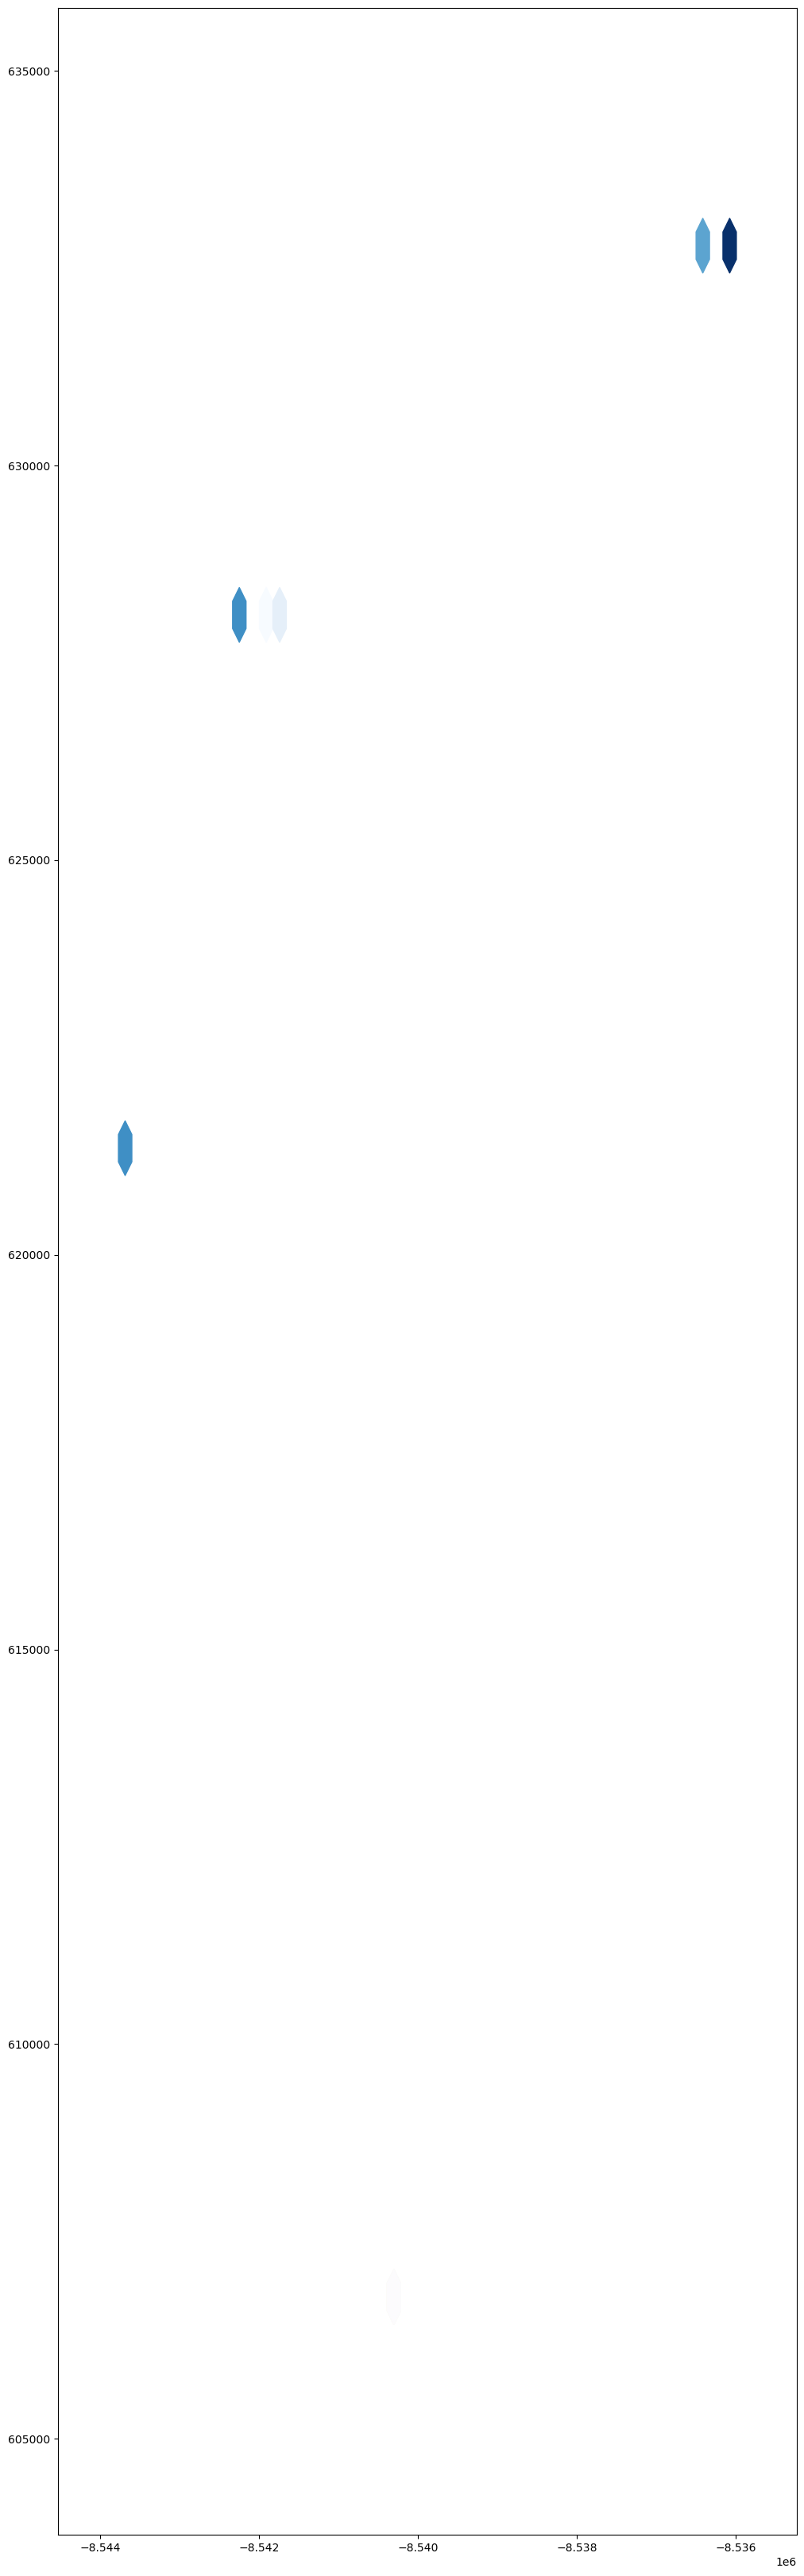

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Load the CSVs
df1 = pd.read_csv("/Users/josele/Library/CloudStorage/GoogleDrive-ejdvc757@gmail.com/Other computers/My MacBook Pro/PhD/Dissertation/3_output/Atrato/Validation/cluster/cluster1_Atrato_river.csv")
df2 = pd.read_csv("/Users/josele/Library/CloudStorage/GoogleDrive-ejdvc757@gmail.com/Other computers/My MacBook Pro/PhD/Dissertation/3_output/Atrato/Validation/cluster/cluster2_Atrato_river.csv")
df3 = pd.read_csv("/Users/josele/Library/CloudStorage/GoogleDrive-ejdvc757@gmail.com/Other computers/My MacBook Pro/PhD/Dissertation/3_output/Atrato/Validation/cluster/cluster2_Atrato_river.csv")
df4 = pd.read_csv("/Users/josele/Library/CloudStorage/GoogleDrive-ejdvc757@gmail.com/Other computers/My MacBook Pro/PhD/Dissertation/3_output/Atrato/Validation/cluster/cluster2_Atrato_river.csv")

df1["source"] = "CSV1"
df2["source"] = "CSV2"
df3["source"] = "CSV3"
df4["source"] = "CSV4"

combined = pd.concat([df1, df2, df3, df4], ignore_index=True)

# --- 2. Create GeoDataFrame and reproject ---
gdf = gpd.GeoDataFrame(
    combined,
    geometry=gpd.points_from_xy(combined["lon"], combined["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# --- 3. Extract coordinates and sources ---
x = gdf.geometry.x.values
y = gdf.geometry.y.values
src = gdf["source"].values

# --- 4. Plot with more intense hexbin colors ---
fig, ax = plt.subplots(figsize=(12, 10))

# CSV2 - Reds
hb2 = ax.hexbin(
    x[src == "CSV2"], y[src == "CSV2"],
    gridsize=50, cmap='Reds',
    mincnt=1, edgecolors='none', linewidths=0,
    alpha=1,  # less transparency
    vmin=1      # increases intensity of lighter bins
)

# CSV1 - Blues
hb1 = ax.hexbin(
    x[src == "CSV1"], y[src == "CSV1"],
    gridsize=50, cmap='Blues',
    mincnt=1, edgecolors='none', linewidths=0,
    alpha=1,  # you can adjust to 0.8 as well
    vmin=1
)

# CSV3 - Greens
hb3 = ax.hexbin(
    x[src == "CSV3"], y[src == "CSV3"],
    gridsize=50, cmap='Greens',
    mincnt=1, edgecolors='none', linewidths=0,
    alpha=1,  # you can adjust to 0.8 as well
    vmin=1
)
# CSV4 - Purples
hb4 = ax.hexbin(
    x[src == "CSV4"], y[src == "CSV4"],
    gridsize=50, cmap='Purples',
    mincnt=1, edgecolors='none', linewidths=0,
    alpha=1,  # you can adjust to 0.8 as well
    vmin=1
)


# --- 5. Add basemap ---
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# --- 6. Maintain correct aspect ratio ---
ax.set_aspect('equal')

# --- 7. Legend and Titles ---
handles = [
    plt.Line2D([], [], color='blue', marker='s', linestyle='None', label='WSE < 33 m'),
    plt.Line2D([], [], color='red', marker='s', linestyle='None', label='33 ≤ WSE < 37 m'),
    plt.Line2D([], [], color='green', marker='s', linestyle='None', label='37 ≤ WSE < 42 m'),
    plt.Line2D([], [], color='purple', marker='s', linestyle='None', label='WSE ≥ 42 m')
]
ax.legend(handles=handles, loc='upper right')

ax.set_title("Hexbin Density: CSV1 vs CSV2 (Enhanced Color on Satellite)")
ax.set_axis_off()



plt.tight_layout()
plt.show()
